In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
wifistats_df = pd.read_csv("./data/wifistats.csv")
extra_info_df = pd.read_csv("./data/extra_info.csv")
devices_df = pd.read_csv("./data/devices.csv")
df = pd.merge(wifistats_df, extra_info_df, on="label", how="inner")
df.head()

,label,time,signal (dBm),packet_loss,connected_time (s),tx_bitrate (MBit/s),rx_bitrate (MBit/s),min_ping_rtt (ms),avg_ping_rtt (ms),max_ping_rtt (ms),mdev_ping_rtt (ms),latitude,longitude
0,raspi-e4:5f:01:84:8c:99,2024-02-13 00:46:21.750007,-65.0,0.0,546569.0,200.0,150.0,3.308,3.878,4.840,0.572,34.413869,-119.841237
1,raspi-e4:5f:01:84:8c:99,2024-02-13 00:56:37.584578,-66.0,0.0,547196.0,200.0,150.0,3.474,5.106,6.327,0.999,34.413869,-119.841237
2,raspi-e4:5f:01:84:8c:99,2024-02-13 01:07:13.715263,-67.0,0.0,547813.0,200.0,150.0,3.801,4.473,5.712,0.683,34.413869,-119.841237
3,raspi-e4:5f:01:84:8c:99,2024-02-13 01:17:39.679114,-67.0,0.0,548450.0,200.0,121.5,4.044,4.276,4.511,0.150,34.413869,-119.841237
4,raspi-e4:5f:01:84:8c:99,2024-02-13 01:28:05.725746,-66.0,0.0,549078.0,180.0,121.5,3.442,4.189,5.267,0.793,34.413869,-119.841237


# Cory's code:

In [3]:
def plot_within_hour(df, year, month, day, hour, metric, devices):
    """
    Plots the specified metric over the specified hour for the given devices.
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data. Must include 'time', 'label', and the specified metric columns.
    - year (int): The year of the hour to plot.
    - month (int): The month of the hour to plot.
    - day (int): The day of the hour to plot.
    - hour (int): The hour (in 24-hour format) to plot.
    - metric (str): The name of the metric column to plot (e.g., 'signal', 'tx_bitrate').
    - devices (list of str): The list of device labels to include in the plot.
    Returns:
    - None: Displays the plot.
    Raises:
    - ValueError: If any device in 'devices' is not found in the DataFrame.
    - ValueError: If the 'metric' is not present in the DataFrame.
    """

    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])
    # Check if all devices are present in the DataFrame
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )

    # Filter for the specified devices
    df_filtered = df[df["label"].isin(devices)]
    # Create a datetime range for the specified hour
    start_time = pd.Timestamp(year, month, day, hour)
    end_time = start_time + pd.Timedelta(hours=1)
    # Filter the DataFrame for the specified hour
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return
    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")

    # Handle missing values in the metric column
    df_filtered = df_filtered.dropna(subset=[metric])

    # Plot the data
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_filtered, x="time", y=metric, hue="label", marker="o")
    # Set plot title and labels
    plt.title(f"{metric} over time on {year}-{month:02d}-{day:02d} Hour {hour:02d}")
    plt.xlabel("Time")
    plt.ylabel(metric.capitalize())
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    # Move the legend outside the plot
    plt.legend(title="Device Label", bbox_to_anchor=(1.05, 1), loc="upper left")
    # Adjust layout to prevent clipping
    plt.tight_layout()
    # Show the plot
    plt.show()


def plot_within_day(df, year, month, day, metric, devices):
    """
    Plots the average, max, and min of the specified metric for each hour within the specified day.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data. Must include 'time', 'label', and the specified metric columns.
    - year (int): The year to plot.
    - month (int): The month to plot.
    - day (int): The day to plot.
    - metric (str): The name of the metric column to plot (e.g., 'signal', 'tx_bitrate').
    - devices (list of str): The list of device labels to include in the plot.

    Returns:
    - None: Displays the plot.
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])
    # Check if all devices are present
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )

    # Filter by devices
    df_filtered = df[df["label"].isin(devices)]
    # Filter by date
    start_time = pd.Timestamp(year, month, day)
    end_time = start_time + pd.Timedelta(days=1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return

    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")
    df_filtered = df_filtered.dropna(subset=[metric])
    # Extract hour
    df_filtered["hour"] = df_filtered["time"].dt.hour
    # Group by hour and label
    df_grouped = (
        df_filtered.groupby(["hour", "label"])[metric]
        .agg(["mean", "max", "min"])
        .reset_index()
    )

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    for device in devices:
        df_device = df_grouped[df_grouped["label"] == device]
        plt.plot(
            df_device["hour"], df_device["mean"], marker="o", label=f"{device} Mean"
        )
        plt.fill_between(
            df_device["hour"],
            df_device["min"],
            df_device["max"],
            alpha=0.2,
            label=f"{device} Min/Max",
        )
    plt.title(f"{metric} over each hour on {year}-{month:02d}-{day:02d}")
    plt.xlabel("Hour")
    plt.ylabel(metric.capitalize())
    plt.xticks(range(0, 24))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_within_month(df, year, month, metric, devices):
    """
    Plots the average, max, and min of the specified metric for each day within the specified month.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - year (int): The year to plot.
    - month (int): The month to plot.
    - metric (str): The name of the metric column to plot.
    - devices (list of str): The list of device labels to include.

    Returns:
    - None
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])
    # Check if all devices are present
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )
    # Filter by devices
    df_filtered = df[df["label"].isin(devices)]

    # Filter by month
    start_time = pd.Timestamp(year, month, 1)
    if month == 12:
        end_time = pd.Timestamp(year + 1, 1, 1)
    else:
        end_time = pd.Timestamp(year, month + 1, 1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]
    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return
    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")

    df_filtered = df_filtered.dropna(subset=[metric])
    # Extract day
    df_filtered["day"] = df_filtered["time"].dt.day
    # Group by day and label
    df_grouped = (
        df_filtered.groupby(["day", "label"])[metric]
        .agg(["mean", "max", "min"])
        .reset_index()
    )

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))

    for device in devices:
        df_device = df_grouped[df_grouped["label"] == device]
        plt.plot(
            df_device["day"], df_device["mean"], marker="o", label=f"{device} Mean"
        )
        plt.fill_between(
            df_device["day"],
            df_device["min"],
            df_device["max"],
            alpha=0.2,
            label=f"{device} Min/Max",
        )
    plt.title(f"{metric} over each day in {year}-{month:02d}")
    plt.xlabel("Day")
    plt.ylabel(metric.capitalize())
    plt.xticks(range(1, 32))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_within_year(df, year, metric, devices):
    """
    Plots the average, max, and min of the specified metric for each month within the specified year.
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - year (int): The year to plot.
    - metric (str): The name of the metric column to plot.
    - devices (list of str): The list of device labels to include.
    Returns:
    - None
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])

    # Check if all devices are present
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )
    # Filter by devices
    df_filtered = df[df["label"].isin(devices)]
    # Filter by year
    start_time = pd.Timestamp(year, 1, 1)
    end_time = pd.Timestamp(year + 1, 1, 1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return
    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")
    df_filtered = df_filtered.dropna(subset=[metric])
    # Extract month
    df_filtered["month"] = df_filtered["time"].dt.month
    # Group by month and label
    df_grouped = (
        df_filtered.groupby(["month", "label"])[metric]
        .agg(["mean", "max", "min"])
        .reset_index()
    )

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    for device in devices:
        df_device = df_grouped[df_grouped["label"] == device]
        plt.plot(
            df_device["month"], df_device["mean"], marker="o", label=f"{device} Mean"
        )
        plt.fill_between(
            df_device["month"],
            df_device["min"],
            df_device["max"],
            alpha=0.2,
            label=f"{device} Min/Max",
        )
    plt.title(f"{metric} over each month in {year}")
    plt.xlabel("Month")
    plt.ylabel(metric.capitalize())
    plt.xticks(range(1, 13))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [4]:
import pandas as pd

wifistats_df['time'] = pd.to_datetime(wifistats_df['time'])
device_label = 'raspi-e4:5f:01:84:8c:99'
date_of_interest = '2024-02-13'
filtered_df = wifistats_df[(wifistats_df['label'] == device_label) & 
                           (wifistats_df['time'].dt.date == pd.to_datetime(date_of_interest).date())]
result_df = filtered_df[['label', 'time', 'tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)']]
result_df.head()

,label,time,tx_bitrate (MBit/s),rx_bitrate (MBit/s)
0,raspi-e4:5f:01:84:8c:99,2024-02-13 00:46:21.750007,200.0,150.0
73,raspi-e4:5f:01:84:8c:99,2024-02-13 00:56:37.584578,200.0,150.0
114,raspi-e4:5f:01:84:8c:99,2024-02-13 01:07:13.715263,200.0,150.0
174,raspi-e4:5f:01:84:8c:99,2024-02-13 01:17:39.679114,200.0,121.5
262,raspi-e4:5f:01:84:8c:99,2024-02-13 01:28:05.725746,180.0,121.5


In [5]:
import pandas as pd
wifistats_df['time'] = pd.to_datetime(wifistats_df['time'])
device_label = 'raspi-e4:5f:01:84:8c:99'
date_of_interest = '2024-02-13'

filtered_df = wifistats_df[(wifistats_df['label'] == device_label) & 
                           (wifistats_df['time'].dt.date == pd.to_datetime(date_of_interest).date())]
result_df = filtered_df[['label', 'time', 'tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)']]
result_df.head()

,label,time,tx_bitrate (MBit/s),rx_bitrate (MBit/s)
0,raspi-e4:5f:01:84:8c:99,2024-02-13 00:46:21.750007,200.0,150.0
73,raspi-e4:5f:01:84:8c:99,2024-02-13 00:56:37.584578,200.0,150.0
114,raspi-e4:5f:01:84:8c:99,2024-02-13 01:07:13.715263,200.0,150.0
174,raspi-e4:5f:01:84:8c:99,2024-02-13 01:17:39.679114,200.0,121.5
262,raspi-e4:5f:01:84:8c:99,2024-02-13 01:28:05.725746,180.0,121.5


In [6]:
def filter_within_hour(df, year, month, day, hour, metric, devices):
    """
    Filters the specified metric over the specified hour for the given devices.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - year (int): The year of the hour to filter.
    - month (int): The month of the hour to filter.
    - day (int): The day of the hour to filter.
    - hour (int): The hour (in 24-hour format) to filter.
    - metric (str): The name of the metric column to filter (e.g., 'signal', 'tx_bitrate').
    - devices (list of str): The list of device labels to include in the filter.

    Returns:
    - pd.DataFrame: The filtered DataFrame.

    Raises:
    - ValueError: If any device in 'devices' is not found in the DataFrame.
    - ValueError: If the 'metric' is not present in the DataFrame.
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )
    df_filtered = df[df["label"].isin(devices)]
    start_time = pd.Timestamp(year, month, day, hour)
    end_time = start_time + pd.Timedelta(hours=1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]
    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return None
    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")
    df_filtered = df_filtered.dropna(subset=[metric])
    return df_filtered

In [7]:
filtered_data = filter_within_hour(
    df,
    2024,
    9,
    22,
    10,
    "signal (dBm)",
    ["raspi-e4:5f:01:8e:27:aa", "raspi-e4:5f:01:a7:b2:7e", "raspi-e4:5f:01:9b:84:c4"]
)

if filtered_data is not None:
    print(filtered_data.head())
    print(filtered_data.describe())
    filtered_data["time_diff"] = filtered_data["time"].diff()
    print(filtered_data["time_diff"].value_counts())

                           label                       time  signal (dBm)  \
2819005  raspi-e4:5f:01:9b:84:c4 2024-09-22 10:04:49.152130         -36.0   
2819006  raspi-e4:5f:01:9b:84:c4 2024-09-22 10:15:04.844480         -36.0   
2819007  raspi-e4:5f:01:9b:84:c4 2024-09-22 10:25:20.435505         -36.0   
2819008  raspi-e4:5f:01:9b:84:c4 2024-09-22 10:35:36.099450         -37.0   
2819009  raspi-e4:5f:01:9b:84:c4 2024-09-22 10:45:51.870572         -36.0   

         packet_loss  connected_time (s)  tx_bitrate (MBit/s)  \
2819005          0.0              2167.0                180.0   
2819006          0.0              2781.0                200.0   
2819007          0.0              3395.0                180.0   
2819008          0.0              4008.0                200.0   
2819009          0.0              4622.0                200.0   

         rx_bitrate (MBit/s)  min_ping_rtt (ms)  avg_ping_rtt (ms)  \
2819005                180.0              4.103              4.714   
281900

=== Original DataFrame Analysis ===
Shape: (4109482, 13)

Columns: ['label', 'time', 'signal (dBm)', 'packet_loss', 'connected_time (s)', 'tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)', 'min_ping_rtt (ms)', 'avg_ping_rtt (ms)', 'max_ping_rtt (ms)', 'mdev_ping_rtt (ms)', 'latitude', 'longitude']

Data Types:
 label                   object
time                    object
signal (dBm)           float64
packet_loss            float64
connected_time (s)     float64
tx_bitrate (MBit/s)    float64
rx_bitrate (MBit/s)    float64
min_ping_rtt (ms)      float64
avg_ping_rtt (ms)      float64
max_ping_rtt (ms)      float64
mdev_ping_rtt (ms)     float64
latitude               float64
longitude              float64
dtype: object

Missing Values:
 label                   0
time                    0
signal (dBm)            0
packet_loss             0
connected_time (s)      0
tx_bitrate (MBit/s)     0
rx_bitrate (MBit/s)     0
min_ping_rtt (ms)      61
avg_ping_rtt (ms)      61
max_ping_rtt (ms)      

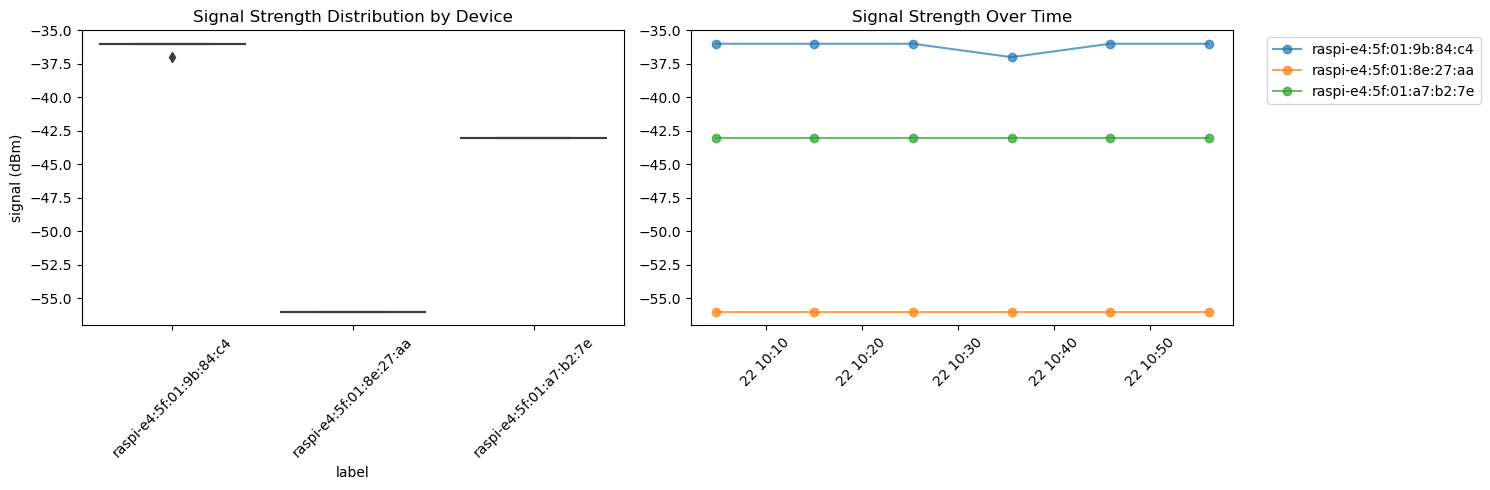


No feature columns found yet. Run feature engineering first.


In [8]:
def perform_eda(df, filtered_data=None):
    """
    Performs comprehensive exploratory data analysis on WiFi statistics data.
    
    Parameters:
    - df: Original DataFrame
    - filtered_data: Optional filtered DataFrame for specific analysis
    """
    # 1. Original DataFrame Analysis
    print("=== Original DataFrame Analysis ===")
    print(f"Shape: {df.shape}")
    print("\nColumns:", df.columns.tolist())
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nSample of first few rows:\n", df.head())

    # 2. Device Analysis
    print("\n=== Unique Devices ===")
    print("Devices:", df['label'].unique())
    print(f"Total unique devices: {df['label'].nunique()}")

    # 3. Time Analysis
    print("\n=== Time Range Analysis ===")
    df['time'] = pd.to_datetime(df['time'])
    print(f"Start date: {df['time'].min()}")
    print(f"End date: {df['time'].max()}")
    print(f"Total time span: {df['time'].max() - df['time'].min()}")

    # 4. Filtered Data Analysis (if provided)
    if filtered_data is not None:
        analyze_filtered_data(filtered_data)

def analyze_filtered_data(filtered_data):
    """Helper function to analyze filtered dataset"""
    print("\n=== Filtered DataFrame Analysis ===")
    filtered_data['time'] = pd.to_datetime(filtered_data['time'])
    
    print(f"Shape: {filtered_data.shape}")
    print("\nColumns:", filtered_data.columns.tolist())
    print("\nData Types:\n", filtered_data.dtypes)
    print("\nMissing Values:\n", filtered_data.isnull().sum())
    
    # Signal Analysis
    print("\n=== Signal Strength Statistics ===")
    print(filtered_data.groupby('label')['signal (dBm)'].describe())
    
    # Time Interval Analysis
    print("\n=== Time Intervals Between Measurements ===")
    filtered_data['time_diff'] = filtered_data.groupby('label')['time'].diff()
    print(filtered_data.groupby('label')['time_diff'].describe())
    
    # Visualizations
    create_visualizations(filtered_data)
    
    # Feature Analysis
    analyze_features(filtered_data)

def create_visualizations(filtered_data):
    """Creates standard visualizations for the filtered data"""
    plt.figure(figsize=(15, 5))
    
    # Signal Distribution
    plt.subplot(121)
    sns.boxplot(data=filtered_data, x='label', y='signal (dBm)')
    plt.xticks(rotation=45)
    plt.title('Signal Strength Distribution by Device')
    
    # Time Series
    plt.subplot(122)
    for label in filtered_data['label'].unique():
        device_data = filtered_data[filtered_data['label'] == label]
        plt.plot(device_data['time'], device_data['signal (dBm)'], 
                label=label, marker='o', linestyle='-', alpha=0.7)
    plt.title('Signal Strength Over Time')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def analyze_features(filtered_data):
    """Analyzes engineered features if they exist"""
    feature_columns = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 
                      'rolling_std_3', 'hour', 'minute']
    existing_features = [col for col in feature_columns if col in filtered_data.columns]
    
    if existing_features:
        print("\n=== Created Features Statistics ===")
        print(filtered_data[existing_features].describe())
        
        # Correlation Analysis
        plt.figure(figsize=(10, 8))
        correlation_matrix = filtered_data[['signal (dBm)'] + existing_features].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo feature columns found yet. Run feature engineering first.")

# Execute the analysis
perform_eda(df, filtered_data)

In [9]:
df['hour'] = pd.to_datetime(df['time']).dt.hour
print("Time Column vs Extracted Hour:")
print(df[['time', 'hour']].head(100))

Time Column vs Extracted Hour:
                         time  hour
0  2024-02-13 00:46:21.750007     0
1  2024-02-13 00:56:37.584578     0
2  2024-02-13 01:07:13.715263     1
3  2024-02-13 01:17:39.679114     1
4  2024-02-13 01:28:05.725746     1
5  2024-02-13 01:38:31.621677     1
6  2024-02-13 01:48:57.696902     1
7  2024-02-13 01:59:13.364732     1
8  2024-02-13 02:09:29.092882     2
9  2024-02-13 02:19:44.893283     2
10 2024-02-13 02:30:10.978906     2
11 2024-02-13 02:40:26.739441     2
12 2024-02-13 02:50:42.482783     2
13 2024-02-13 03:00:58.185842     3
14 2024-02-13 03:11:24.198325     3
15 2024-02-13 03:21:39.849323     3
16 2024-02-13 03:32:05.802359     3
17 2024-02-13 03:42:31.739830     3
18 2024-02-13 03:52:57.669780     3
19 2024-02-13 04:03:23.664623     4
20 2024-02-13 04:13:39.503259     4
21 2024-02-13 04:24:05.402050     4
22 2024-02-13 04:34:31.498404     4
23 2024-02-13 04:44:57.382945     4
24 2024-02-13 04:55:23.319750     4
25 2024-02-13 05:05:38.947812    

In [10]:
import pandas as pd
wifistats_df['time'] = pd.to_datetime(wifistats_df['time'])
device_label = 'raspi-e4:5f:01:84:8c:99'
date_of_interest = '2024-02-13'
filtered_df = wifistats_df[(wifistats_df['label'] == device_label) & 
                           (wifistats_df['time'].dt.date == pd.to_datetime(date_of_interest).date())]
result_df = filtered_df[['label', 'time', 'tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)']]
print(result_df)

                           label                       time  \
0        raspi-e4:5f:01:84:8c:99 2024-02-13 00:46:21.750007   
73       raspi-e4:5f:01:84:8c:99 2024-02-13 00:56:37.584578   
114      raspi-e4:5f:01:84:8c:99 2024-02-13 01:07:13.715263   
174      raspi-e4:5f:01:84:8c:99 2024-02-13 01:17:39.679114   
262      raspi-e4:5f:01:84:8c:99 2024-02-13 01:28:05.725746   
329      raspi-e4:5f:01:84:8c:99 2024-02-13 01:38:31.621677   
383      raspi-e4:5f:01:84:8c:99 2024-02-13 01:48:57.696902   
452      raspi-e4:5f:01:84:8c:99 2024-02-13 01:59:13.364732   
530      raspi-e4:5f:01:84:8c:99 2024-02-13 02:09:29.092882   
592      raspi-e4:5f:01:84:8c:99 2024-02-13 02:19:44.893283   
623      raspi-e4:5f:01:84:8c:99 2024-02-13 02:30:10.978906   
727      raspi-e4:5f:01:84:8c:99 2024-02-13 02:40:26.739441   
790      raspi-e4:5f:01:84:8c:99 2024-02-13 02:50:42.482783   
838      raspi-e4:5f:01:84:8c:99 2024-02-13 03:00:58.185842   
887      raspi-e4:5f:01:84:8c:99 2024-02-13 03:11:24.19

# REGRESSION HERE
Look at the data: I picked this device: raspi-e4:5f:01:84:8c:99' and the day 2024-02-13 as an example and printed and plotted the data. Based on this data, and the variables in the wifistats data we can apply some regression modeling which uses time as a feature B1 (we will add one or two more features to this model) to predict the tx_bitrate (MBit/s) and rx_bitrate (MBit/s) for the device. 

In [11]:
import pandas as pd
wifistats_df['time'] = pd.to_datetime(wifistats_df['time'])
device_label = 'raspi-e4:5f:01:84:8c:99'
date_of_interest = '2024-02-13'
filtered_df = wifistats_df[(wifistats_df['label'] == device_label) & 
                           (wifistats_df['time'].dt.date == pd.to_datetime(date_of_interest).date())]
result_df = filtered_df[['label', 'time', 'tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)']]
result_df.head()

,label,time,tx_bitrate (MBit/s),rx_bitrate (MBit/s)
0,raspi-e4:5f:01:84:8c:99,2024-02-13 00:46:21.750007,200.0,150.0
73,raspi-e4:5f:01:84:8c:99,2024-02-13 00:56:37.584578,200.0,150.0
114,raspi-e4:5f:01:84:8c:99,2024-02-13 01:07:13.715263,200.0,150.0
174,raspi-e4:5f:01:84:8c:99,2024-02-13 01:17:39.679114,200.0,121.5
262,raspi-e4:5f:01:84:8c:99,2024-02-13 01:28:05.725746,180.0,121.5


/var/folders/bm/dh8z1y295zx4278nbfwzcvz40000gn/T/ipykernel_92384/2159772311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['time'] = pd.to_datetime(result_df['time'])


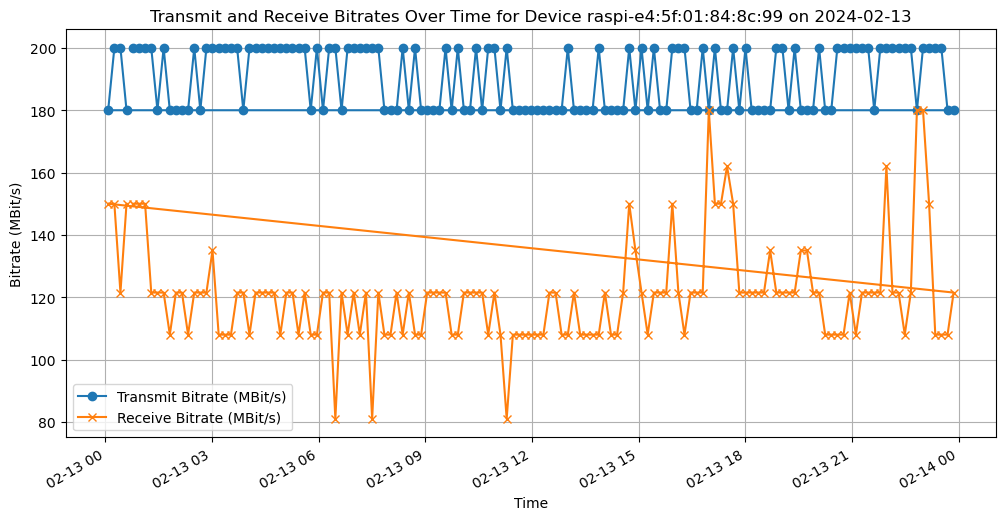

In [12]:
import matplotlib.pyplot as plt
result_df['time'] = pd.to_datetime(result_df['time'])
plt.figure(figsize=(12, 6))
plt.plot(result_df['time'], result_df['tx_bitrate (MBit/s)'], label='Transmit Bitrate (MBit/s)', marker='o')
plt.plot(result_df['time'], result_df['rx_bitrate (MBit/s)'], label='Receive Bitrate (MBit/s)', marker='x')
plt.xlabel('Time')
plt.ylabel('Bitrate (MBit/s)')
plt.title('Transmit and Receive Bitrates Over Time for Device raspi-e4:5f:01:84:8c:99 on 2024-02-13')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()

Interesting: if we look at the fact that receive rates vary more than transmit rates this is lilely pretty common - intuitively it's often harder to "hear" clearly (receive) than to "speak" clearly (transmit) - also especially if there's interference or if you're farther from the WiFi access point.

In [13]:
print("Unique labels:", filtered_df['label'].unique())
print("Date range:", filtered_df['time'].dt.date.unique())

Unique labels: ['raspi-e4:5f:01:84:8c:99']
Date range: [datetime.date(2024, 2, 13)]


In [14]:
import pandas as pd

wifistats_df['time'] = pd.to_datetime(wifistats_df['time'])
device_label = 'raspi-e4:5f:01:84:8c:99'
date_of_interest = '2024-02-13'

filtered_df = wifistats_df[(wifistats_df['label'] == device_label) & 
                          (wifistats_df['time'].dt.date == pd.to_datetime(date_of_interest).date())]
result_df = filtered_df[['time', 'rx_bitrate (MBit/s)']]
lowest_rx = result_df.nsmallest(5, 'rx_bitrate (MBit/s)')
print(lowest_rx)

                           time  rx_bitrate (MBit/s)
2142 2024-02-13 06:28:15.414733                 81.0
2517 2024-02-13 07:30:20.127532                 81.0
3912 2024-02-13 11:17:17.629812                 81.0
383  2024-02-13 01:48:57.696902                108.0
592  2024-02-13 02:19:44.893283                108.0


In [15]:
#10 lowest rx_bitrate readings from the entire dataset
lowest_rx = wifistats_df[['label', 'time', 'rx_bitrate (MBit/s)']].nsmallest(10, 'rx_bitrate (MBit/s)')
print("10 Lowest RX Bitrates in the Dataset:")
print(lowest_rx)

10 Lowest RX Bitrates in the Dataset:
                          label                       time  \
954252  raspi-e4:5f:01:8d:ca:e0 2024-06-25 22:57:34.469803   
954262  raspi-e4:5f:01:ac:e1:df 2024-06-25 22:57:34.474332   
954386  raspi-e4:5f:01:8d:ca:e0 2024-06-25 23:28:21.729750   
965223  raspi-e4:5f:01:8d:ca:e0 2024-06-27 08:26:19.174548   
965281  raspi-e4:5f:01:8d:ca:e0 2024-06-27 08:36:45.106588   
965337  raspi-e4:5f:01:8d:ca:e0 2024-06-27 08:47:00.826625   
965394  raspi-e4:5f:01:8d:ca:e0 2024-06-27 08:57:26.771332   
965452  raspi-e4:5f:01:8d:ca:e0 2024-06-27 09:07:42.512468   
965509  raspi-e4:5f:01:ac:e1:df 2024-06-27 09:17:58.204868   
965566  raspi-e4:5f:01:ac:e1:df 2024-06-27 09:28:13.912891   

        rx_bitrate (MBit/s)  
954252                  1.0  
954262                  1.0  
954386                  1.0  
965223                  1.0  
965281                  1.0  
965337                  1.0  
965394                  1.0  
965452                  1.0  
965509   

Very low rx_bitrate values are often due to interference or distance from the WiFi access point. These are only occuring in 2 devices:
raspi-e4:5f:01:8d:ca:e0
raspi-e4:5f:01:ac:e1:df
in cluster times of January 25, 2024 and January 27, 2024 around 22:57-23:28 and 08:26-09:28 respectively.

RX Bitrate Statistics:
count    4.673158e+06
mean     1.039566e+02
std      6.941162e+01
min      1.000000e+00
25%      5.770000e+01
50%      7.220000e+01
75%      2.000000e+02
max      4.333000e+02
Name: rx_bitrate (MBit/s), dtype: float64

RX Bitrate Statistics for the Problem Devices:
count    46324.000000
mean        46.743632
std         61.827548
min          1.000000
25%          1.000000
50%         39.000000
75%         65.000000
max        433.300000
Name: rx_bitrate (MBit/s), dtype: float64


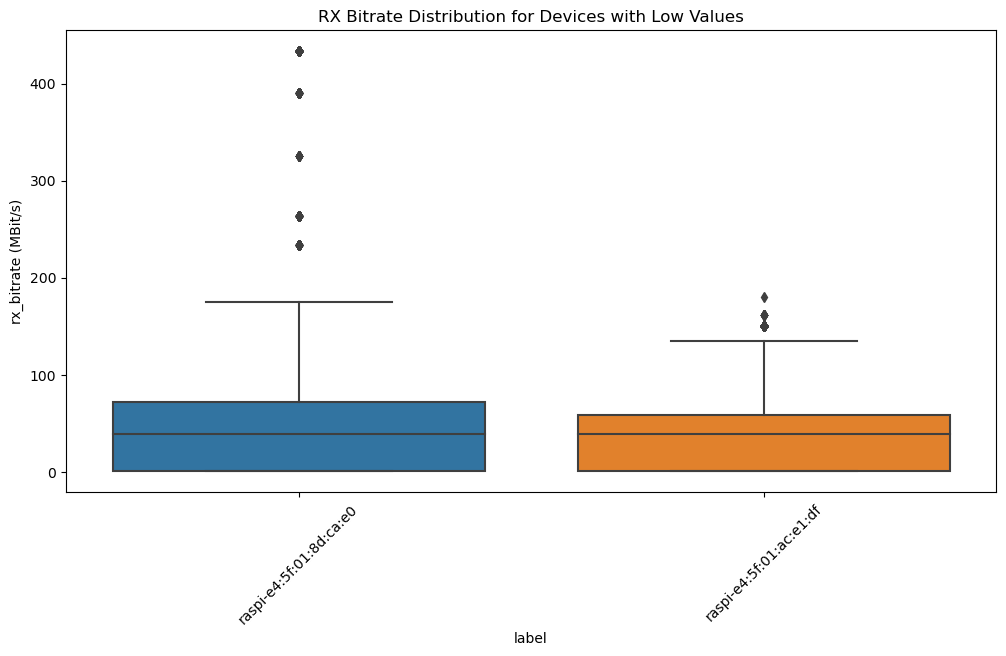

In [16]:
print("RX Bitrate Statistics:")
print(wifistats_df['rx_bitrate (MBit/s)'].describe())
problem_devices = ['raspi-e4:5f:01:8d:ca:e0', 'raspi-e4:5f:01:ac:e1:df']
device_stats = wifistats_df[wifistats_df['label'].isin(problem_devices)]['rx_bitrate (MBit/s)'].describe()
print("\nRX Bitrate Statistics for the Problem Devices:")
print(device_stats)
plt.figure(figsize=(12, 6))
sns.boxplot(data=wifistats_df[wifistats_df['label'].isin(problem_devices)], x='label', y='rx_bitrate (MBit/s)')
plt.xticks(rotation=45)
plt.title('RX Bitrate Distribution for Devices with Low Values')
plt.show()


Looking at these statistics and the box plot, there are several important insights from both the overall dataset statistics (mean bitrate of ~104 MBit/s, median of 72.2 MBit/s, maximum of 433.3 MBit/s, minimum of 1.0 MBit/s) and the problem devices statistics (much lower mean of ~46.7 MBit/s, lower median of 39 MBit/s, 25% of readings at or below 1.0 MBit/s, same maximum of 433.3 MBit/s and minimum of 1.0 MBit/s). The box plot analysis reveals that both devices show similar distributions, with a large number of outliers at higher bitrates, a large portion of readings in lower ranges, and a wide spread between quartiles indicating high variability.

These patterns suggest that these devices are consistently underperforming compared to the overall dataset, with the 1.0 MBit/s readings not being just isolated incidents but part of a broader pattern of poor performance, and while these devices are capable of higher speeds (as shown by outliers), they frequently operate at much lower rates, possibly due to physical placement issues or persistent interference affecting these specific devices.


0    2024-02-13
1    2024-02-13
2    2024-02-13
3    2024-02-13
4    2024-02-13
Name: date, dtype: object

Unique dates in dataset:
[datetime.date(2023, 4, 6), datetime.date(2023, 4, 7), datetime.date(2023, 4, 8), datetime.date(2023, 4, 9), datetime.date(2023, 4, 10), datetime.date(2023, 4, 11), datetime.date(2023, 4, 12), datetime.date(2023, 4, 13), datetime.date(2023, 4, 14), datetime.date(2023, 4, 15), datetime.date(2023, 4, 16), datetime.date(2023, 4, 17), datetime.date(2023, 4, 18), datetime.date(2023, 4, 19), datetime.date(2023, 4, 20), datetime.date(2023, 4, 21), datetime.date(2023, 4, 22), datetime.date(2023, 4, 23), datetime.date(2023, 4, 24), datetime.date(2023, 4, 25), datetime.date(2023, 4, 26), datetime.date(2023, 4, 27), datetime.date(2023, 4, 28), datetime.date(2023, 4, 29), datetime.date(2023, 4, 30), datetime.date(2023, 5, 1), datetime.date(2023, 5, 2), datetime.date(2023, 5, 3), datetime.date(2023, 5, 4), datetime.date(2023, 5, 5), datetime.date(2023, 5, 6), datetime.

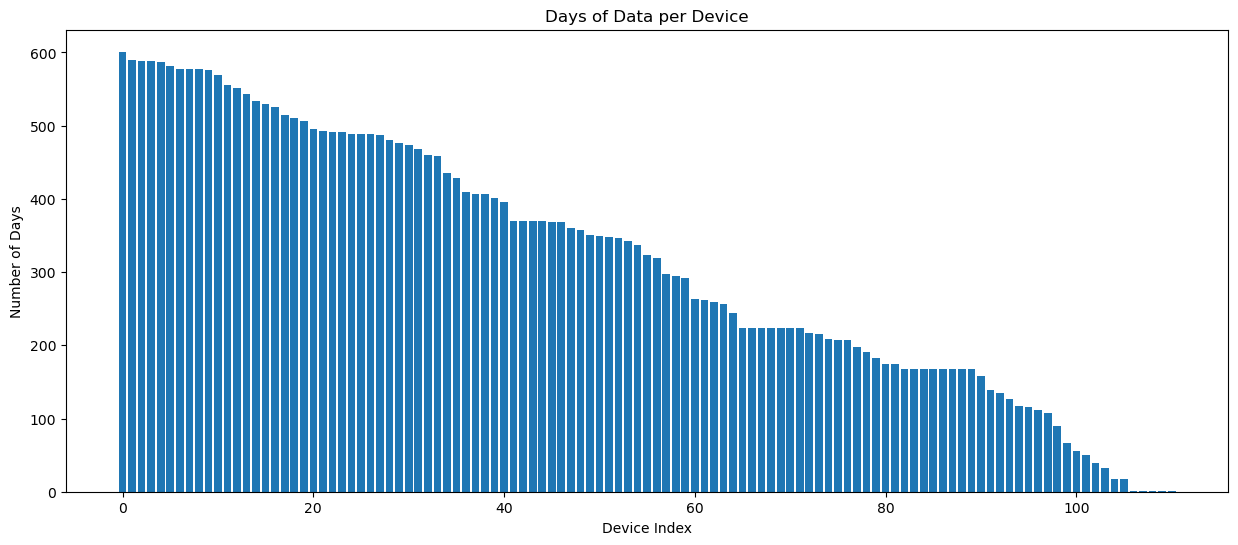

Summary Statistics of Days per Device:
count    111.000000
mean     314.405405
std      177.115698
min        1.000000
25%      167.000000
50%      324.000000
75%      484.000000
max      601.000000
Name: Number of Days, dtype: float64

Total number of devices: 111
Range of days: 1 to 601


In [17]:
# Convert time to datetime if it's not already
wifistats_df['time'] = pd.to_datetime(wifistats_df['time'])

# Extract date from timestamp
wifistats_df['date'] = wifistats_df['time'].dt.date
print(wifistats_df['date'].head())
print("\nUnique dates in dataset:")
print(sorted(wifistats_df['date'].unique()))


# Get unique days count
unique_days = wifistats_df['date'].nunique()
print(f"Total number of unique days in dataset: {unique_days}")

# Get unique devices count
unique_devices = wifistats_df['label'].nunique()
print(f"Total number of unique devices in dataset: {unique_devices}")

# Get days of data per device
days_per_device = (wifistats_df.groupby('label')['date']
                  .nunique()
                  .sort_values(ascending=False)
                  .reset_index())
days_per_device.columns = ['Device', 'Number of Days']

print("\nDays of data per device:")
print(days_per_device)

# Optional: Basic statistics about days per device
print("\nStatistics about days per device:")
print(days_per_device['Number of Days'].describe())

# 3. Simple bar plot showing each device
plt.figure(figsize=(15, 6))
plt.bar(range(len(days_per_device)), days_per_device['Number of Days'])
plt.title('Days of Data per Device')
plt.xlabel('Device Index')
plt.ylabel('Number of Days')
plt.show()

# 4. Print basic statistics instead
print("Summary Statistics of Days per Device:")
print(days_per_device['Number of Days'].describe())
print(f"\nTotal number of devices: {len(days_per_device)}")
print(f"Range of days: {days_per_device['Number of Days'].min()} to {days_per_device['Number of Days'].max()}")



# Exploratory Data Analysis: 
- days in the dataset
- days per device
- and more

In [18]:
unique_dates_df = pd.DataFrame(sorted(wifistats_df['date'].unique()), columns=['Date'])
unique_dates_df['Day of Week'] = pd.to_datetime(unique_dates_df['Date']).dt.strftime('%A')
unique_dates_df.index = range(1, len(unique_dates_df) + 1)
unique_dates_df.index.name = 'Row'
print("\nDates Present in Dataset:")
print(unique_dates_df.to_string())
print(f"\nTotal number of days: {len(unique_dates_df)}")
print(f"Date range: {unique_dates_df['Date'].min()} to {unique_dates_df['Date'].max()}")


Dates Present in Dataset:
           Date Day of Week
Row                        
1    2023-04-06    Thursday
2    2023-04-07      Friday
3    2023-04-08    Saturday
4    2023-04-09      Sunday
5    2023-04-10      Monday
6    2023-04-11     Tuesday
7    2023-04-12   Wednesday
8    2023-04-13    Thursday
9    2023-04-14      Friday
10   2023-04-15    Saturday
11   2023-04-16      Sunday
12   2023-04-17      Monday
13   2023-04-18     Tuesday
14   2023-04-19   Wednesday
15   2023-04-20    Thursday
16   2023-04-21      Friday
17   2023-04-22    Saturday
18   2023-04-23      Sunday
19   2023-04-24      Monday
20   2023-04-25     Tuesday
21   2023-04-26   Wednesday
22   2023-04-27    Thursday
23   2023-04-28      Friday
24   2023-04-29    Saturday
25   2023-04-30      Sunday
26   2023-05-01      Monday
27   2023-05-02     Tuesday
28   2023-05-03   Wednesday
29   2023-05-04    Thursday
30   2023-05-05      Friday
31   2023-05-06    Saturday
32   2023-05-07      Sunday
33   2023-05-08      

=== Transmit (TX) Bitrate Analysis ===

Year 2023, Month 04:
Week 14: Highest TX bitrate on Thursday (2023-04-06) - 200.00 MBit/s
Week 15: Highest TX bitrate on Monday (2023-04-10) - 200.00 MBit/s
Week 16: Highest TX bitrate on Monday (2023-04-17) - 200.00 MBit/s
Week 17: Highest TX bitrate on Monday (2023-04-24) - 200.00 MBit/s

Year 2023, Month 05:
Week 18: Highest TX bitrate on Monday (2023-05-01) - 200.00 MBit/s
Week 19: Highest TX bitrate on Monday (2023-05-08) - 200.00 MBit/s
Week 20: Highest TX bitrate on Monday (2023-05-15) - 200.00 MBit/s
Week 21: Highest TX bitrate on Monday (2023-05-22) - 200.00 MBit/s
Week 22: Highest TX bitrate on Monday (2023-05-29) - 200.00 MBit/s

Year 2023, Month 06:
Week 22: Highest TX bitrate on Thursday (2023-06-01) - 200.00 MBit/s
Week 23: Highest TX bitrate on Monday (2023-06-05) - 200.00 MBit/s
Week 24: Highest TX bitrate on Monday (2023-06-12) - 200.00 MBit/s
Week 25: Highest TX bitrate on Monday (2023-06-19) - 200.00 MBit/s
Week 26: Highest TX 

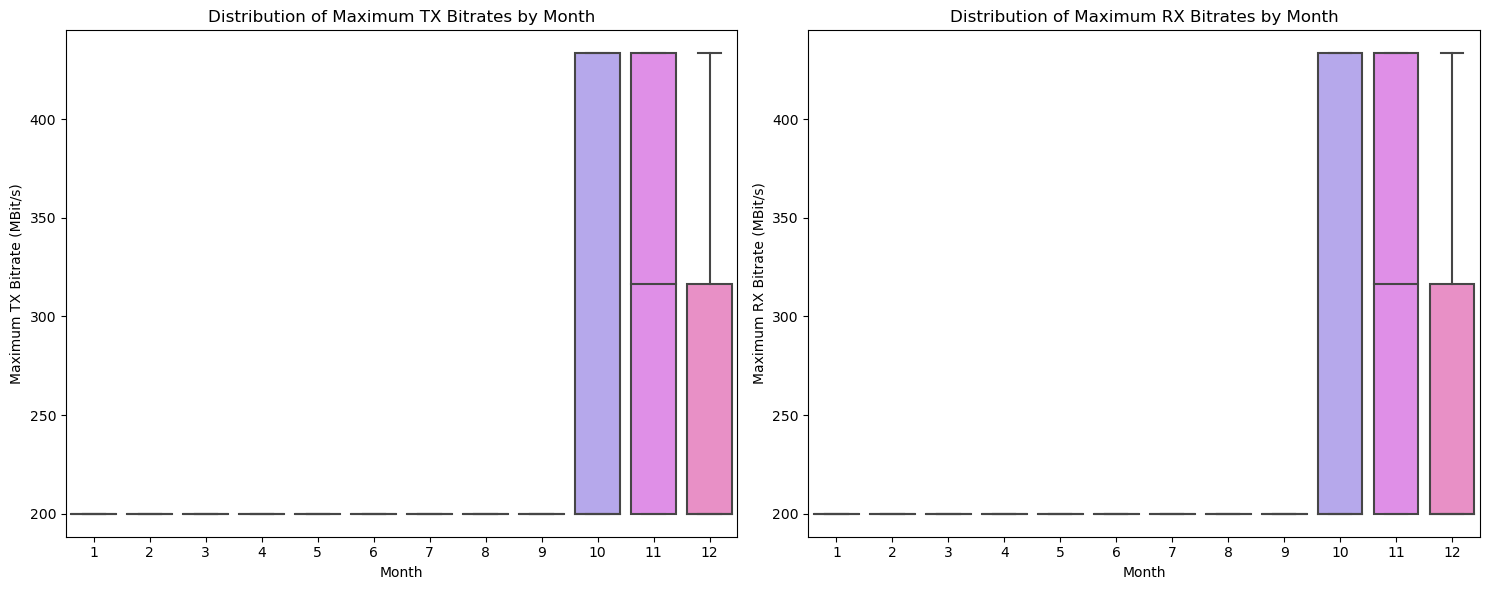

In [19]:
# Create a function to analyze highest bitrates by week and month
def analyze_highest_bitrates_by_week(df):
    # Convert time to datetime if not already
    df['time'] = pd.to_datetime(df['time'])
    
    # Create additional time-based columns
    df['date'] = df['time'].dt.date
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['week'] = df['time'].dt.isocalendar().week
    df['day_name'] = df['time'].dt.strftime('%A')
    
    # Group by year, month, and week to find highest bitrates
    tx_results = []
    rx_results = []
    
    for (year, month, week), group in df.groupby(['year', 'month', 'week']):
        # Find day with highest TX bitrate
        max_tx_idx = group['tx_bitrate (MBit/s)'].idxmax()
        max_tx_row = group.loc[max_tx_idx]
        
        # Find day with highest RX bitrate
        max_rx_idx = group['rx_bitrate (MBit/s)'].idxmax()
        max_rx_row = group.loc[max_rx_idx]
        
        tx_results.append({
            'year': year,
            'month': month,
            'week': week,
            'max_tx_bitrate': max_tx_row['tx_bitrate (MBit/s)'],
            'day_of_week': max_tx_row['day_name'],
            'date': max_tx_row['date']
        })
        
        rx_results.append({
            'year': year,
            'month': month,
            'week': week,
            'max_rx_bitrate': max_rx_row['rx_bitrate (MBit/s)'],
            'day_of_week': max_rx_row['day_name'],
            'date': max_rx_row['date']
        })
    
    tx_df = pd.DataFrame(tx_results)
    rx_df = pd.DataFrame(rx_results)
    
    return tx_df, rx_df

# Run the analysis
tx_results, rx_results = analyze_highest_bitrates_by_week(wifistats_df)

# Display results in a formatted way
def display_results(tx_df, rx_df):
    print("=== Transmit (TX) Bitrate Analysis ===")
    for year in sorted(tx_df['year'].unique()):
        year_data = tx_df[tx_df['year'] == year]
        for month in sorted(year_data['month'].unique()):
            month_data = year_data[year_data['month'] == month]
            print(f"\nYear {year}, Month {month:02d}:")
            for _, row in month_data.sort_values('week').iterrows():
                print(f"Week {row['week']}: Highest TX bitrate on {row['day_of_week']} "
                      f"({row['date']}) - {row['max_tx_bitrate']:.2f} MBit/s")
    
    print("\n=== Receive (RX) Bitrate Analysis ===")
    for year in sorted(rx_df['year'].unique()):
        year_data = rx_df[rx_df['year'] == year]
        for month in sorted(year_data['month'].unique()):
            month_data = year_data[year_data['month'] == month]
            print(f"\nYear {year}, Month {month:02d}:")
            for _, row in month_data.sort_values('week').iterrows():
                print(f"Week {row['week']}: Highest RX bitrate on {row['day_of_week']} "
                      f"({row['date']}) - {row['max_rx_bitrate']:.2f} MBit/s")

# Display the results
display_results(tx_results, rx_results)

# Optional: Create visualizations
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=tx_results, x='month', y='max_tx_bitrate')
plt.title('Distribution of Maximum TX Bitrates by Month')
plt.xlabel('Month')
plt.ylabel('Maximum TX Bitrate (MBit/s)')

plt.subplot(1, 2, 2)
sns.boxplot(data=rx_results, x='month', y='max_rx_bitrate')
plt.title('Distribution of Maximum RX Bitrates by Month')
plt.xlabel('Month')
plt.ylabel('Maximum RX Bitrate (MBit/s)')
plt.tight_layout()
plt.show()

TX analysis saved to: bitrate_analysis_tx.csv
RX analysis saved to: bitrate_analysis_rx.csv
Monthly summary saved to: bitrate_analysis_monthly_summary.csv

Preview of TX Results:
   year  month  week  max_tx_bitrate day_of_week        date  \
0  2023      4    14           200.0    Thursday  2023-04-06   
1  2023      4    15           200.0      Monday  2023-04-10   
2  2023      4    16           200.0      Monday  2023-04-17   
3  2023      4    17           200.0      Monday  2023-04-24   
4  2023      5    18           200.0      Monday  2023-05-01   

                    device                 exact_time  
0  raspi-e4:5f:01:75:54:04 2023-04-06 03:24:43.109515  
1  raspi-e4:5f:01:56:d8:fc 2023-04-10 00:04:33.334485  
2  raspi-e4:5f:01:75:54:04 2023-04-17 00:01:24.321194  
3  raspi-e4:5f:01:75:54:04 2023-04-24 00:19:46.275054  
4  raspi-e4:5f:01:a0:4a:dd 2023-05-01 00:09:56.055853  

Preview of RX Results:
   year  month  week  max_rx_bitrate day_of_week        date  \
0  2023     

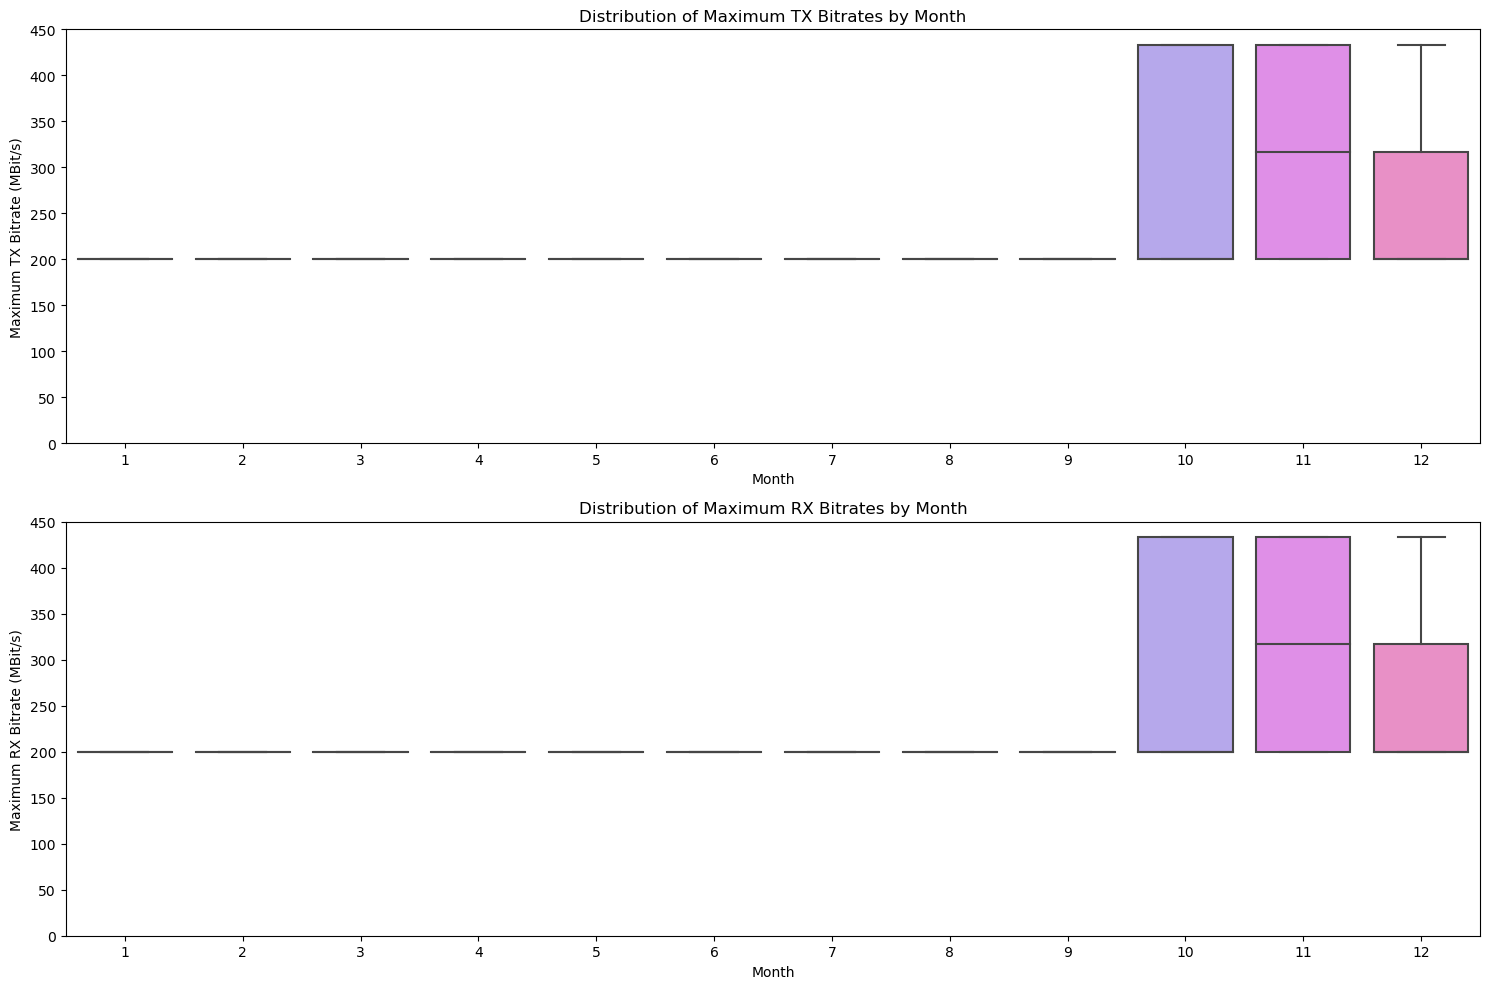

In [20]:
def analyze_and_save_bitrates(df, output_prefix="bitrate_analysis"):
    # Same analysis function as before, but with CSV export
    df['time'] = pd.to_datetime(df['time'])
    
    df['date'] = df['time'].dt.date
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['week'] = df['time'].dt.isocalendar().week
    df['day_name'] = df['time'].dt.strftime('%A')
    
    tx_results = []
    rx_results = []
    
    for (year, month, week), group in df.groupby(['year', 'month', 'week']):
        # TX analysis
        max_tx_idx = group['tx_bitrate (MBit/s)'].idxmax()
        max_tx_row = group.loc[max_tx_idx]
        
        # RX analysis
        max_rx_idx = group['rx_bitrate (MBit/s)'].idxmax()
        max_rx_row = group.loc[max_rx_idx]
        
        tx_results.append({
            'year': year,
            'month': month,
            'week': week,
            'max_tx_bitrate': max_tx_row['tx_bitrate (MBit/s)'],
            'day_of_week': max_tx_row['day_name'],
            'date': max_tx_row['date'],
            'device': max_tx_row['label'],
            'exact_time': max_tx_row['time']
        })
        
        rx_results.append({
            'year': year,
            'month': month,
            'week': week,
            'max_rx_bitrate': max_rx_row['rx_bitrate (MBit/s)'],
            'day_of_week': max_rx_row['day_name'],
            'date': max_rx_row['date'],
            'device': max_rx_row['label'],
            'exact_time': max_rx_row['time']
        })
    
    # Convert to DataFrames
    tx_df = pd.DataFrame(tx_results)
    rx_df = pd.DataFrame(rx_results)
    
    # Sort the DataFrames
    tx_df = tx_df.sort_values(['year', 'month', 'week'])
    rx_df = rx_df.sort_values(['year', 'month', 'week'])
    
    # Save to CSV files
    tx_filename = f"{output_prefix}_tx.csv"
    rx_filename = f"{output_prefix}_rx.csv"
    
    tx_df.to_csv(tx_filename, index=False)
    rx_df.to_csv(rx_filename, index=False)
    
    print(f"TX analysis saved to: {tx_filename}")
    print(f"RX analysis saved to: {rx_filename}")
    
    # Create a summary DataFrame
    summary_data = []
    for (year, month), group in tx_df.groupby(['year', 'month']):
        summary_data.append({
            'year': year,
            'month': month,
            'avg_max_tx': group['max_tx_bitrate'].mean(),
            'avg_max_rx': rx_df[(rx_df['year'] == year) & 
                               (rx_df['month'] == month)]['max_rx_bitrate'].mean(),
            'most_common_tx_day': group['day_of_week'].mode().iloc[0],
            'most_common_rx_day': rx_df[(rx_df['year'] == year) & 
                                      (rx_df['month'] == month)]['day_of_week'].mode().iloc[0],
            'number_of_weeks': len(group)
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values(['year', 'month'])
    summary_filename = f"{output_prefix}_monthly_summary.csv"
    summary_df.to_csv(summary_filename, index=False)
    print(f"Monthly summary saved to: {summary_filename}")
    
    return tx_df, rx_df, summary_df

# Run the analysis and save to CSV
tx_results, rx_results, summary = analyze_and_save_bitrates(wifistats_df)

# Display a preview of the results
print("\nPreview of TX Results:")
print(tx_results.head())
print("\nPreview of RX Results:")
print(rx_results.head())
print("\nPreview of Monthly Summary:")
print(summary.head())

plt.figure(figsize=(15, 10))

# TX Bitrate by Month
plt.subplot(2, 1, 1)
sns.boxplot(data=tx_results, x='month', y='max_tx_bitrate')
plt.title('Distribution of Maximum TX Bitrates by Month')
plt.xlabel('Month')
plt.ylabel('Maximum TX Bitrate (MBit/s)')
plt.ylim(0, 450)  # Set y-axis range from 0 to 450

# RX Bitrate by Month
plt.subplot(2, 1, 2)
sns.boxplot(data=rx_results, x='month', y='max_rx_bitrate')
plt.title('Distribution of Maximum RX Bitrates by Month')
plt.xlabel('Month')
plt.ylabel('Maximum RX Bitrate (MBit/s)')
plt.ylim(0, 450)  # Set y-axis range from 0 to 450

plt.tight_layout()
plt.show()

# Code Explanation:
We are finding the HIGHEST speed for each WEEK, then when we show it in the box plot by month, we're showing:
All the weekly maximum speeds that happened in that month
That's why months 1-9 look flat - because every week in those months had the same maximum speed (200 MBit/s)
And that's why months 10-12 show more variation - because different weeks in those months had different maximum speeds

1. First, we take all our WiFi data and organize it by time:
2. Then, we look at the data in groups. We make groups by:
Year (like 2024)
Month (like January = 1)
Week (like week 1, week 2, etc.)
3. For each week, we find:
The highest TX (sending) speed that happened that week
The highest RX (receiving) speed that happened that week
4. Then, we show the highest speeds for each week in a box plot by month.


This visualization shows the distribution of maximum TX (transmission) and RX (reception) bitrates by month across a time period. The data is presented in two box plots, one for TX and one for RX bitrates.
Key observations:
For most of the period (months 1-9), both TX and RX bitrates remain constant at 200 MBit/s
There's a significant increase in both TX and RX bitrates starting from month 10 (October), jumping to around 433.3 MBit/s
The box plots for months 10-12 show more variation in the data, as indicated by the larger boxes and whiskers
The pattern is identical between TX and RX rates, suggesting symmetric connection speeds
The change appears to represent a network upgrade or configuration change that occurred around October
This kind of visualization is useful for monitoring network performance and identifying significant changes or upgrades in network capacity over time.



the flat lines at 200 MBit/s appear very thin because there's absolutely no variation in the data during those months - every measurement is exactly 200 MBit/s. In contrast, the box plots for months 10-12 are larger because there's variation in the measurements during those months.
A box plot shows:
The median (middle line)
The box represents the interquartile range (IQR: 25th to 75th percentiles)
The whiskers show the range of the data
Any outliers would be shown as individual points
For months 1-9, since every single measurement is exactly 200 MBit/s:
The median is 200
The 25th percentile is 200
The 75th percentile is 200
There's no variation, so the box collapses to a single line


In [21]:
# Check variation in bitrates by month
for month in range(1, 13):
    month_data = rx_results[rx_results['month'] == month]
    print(f"\nMonth {month}:")
    print(f"Number of measurements: {len(month_data)}")
    print(f"Unique bitrate values: {month_data['max_rx_bitrate'].unique()}")
    print(f"Mean: {month_data['max_rx_bitrate'].mean():.1f}")
    print(f"Std Dev: {month_data['max_rx_bitrate'].std():.1f}")


Month 1:
Number of measurements: 5
Unique bitrate values: [200.]
Mean: 200.0
Std Dev: 0.0

Month 2:
Number of measurements: 5
Unique bitrate values: [200.]
Mean: 200.0
Std Dev: 0.0

Month 3:
Number of measurements: 5
Unique bitrate values: [200.]
Mean: 200.0
Std Dev: 0.0

Month 4:
Number of measurements: 9
Unique bitrate values: [200.]
Mean: 200.0
Std Dev: 0.0

Month 5:
Number of measurements: 10
Unique bitrate values: [200.]
Mean: 200.0
Std Dev: 0.0

Month 6:
Number of measurements: 10
Unique bitrate values: [200.]
Mean: 200.0
Std Dev: 0.0

Month 7:
Number of measurements: 11
Unique bitrate values: [200.]
Mean: 200.0
Std Dev: 0.0

Month 8:
Number of measurements: 10
Unique bitrate values: [200.]
Mean: 200.0
Std Dev: 0.0

Month 9:
Number of measurements: 11
Unique bitrate values: [200.]
Mean: 200.0
Std Dev: 0.0

Month 10:
Number of measurements: 11
Unique bitrate values: [200.  433.3]
Mean: 306.0
Std Dev: 121.8

Month 11:
Number of measurements: 10
Unique bitrate values: [200.  433.3]

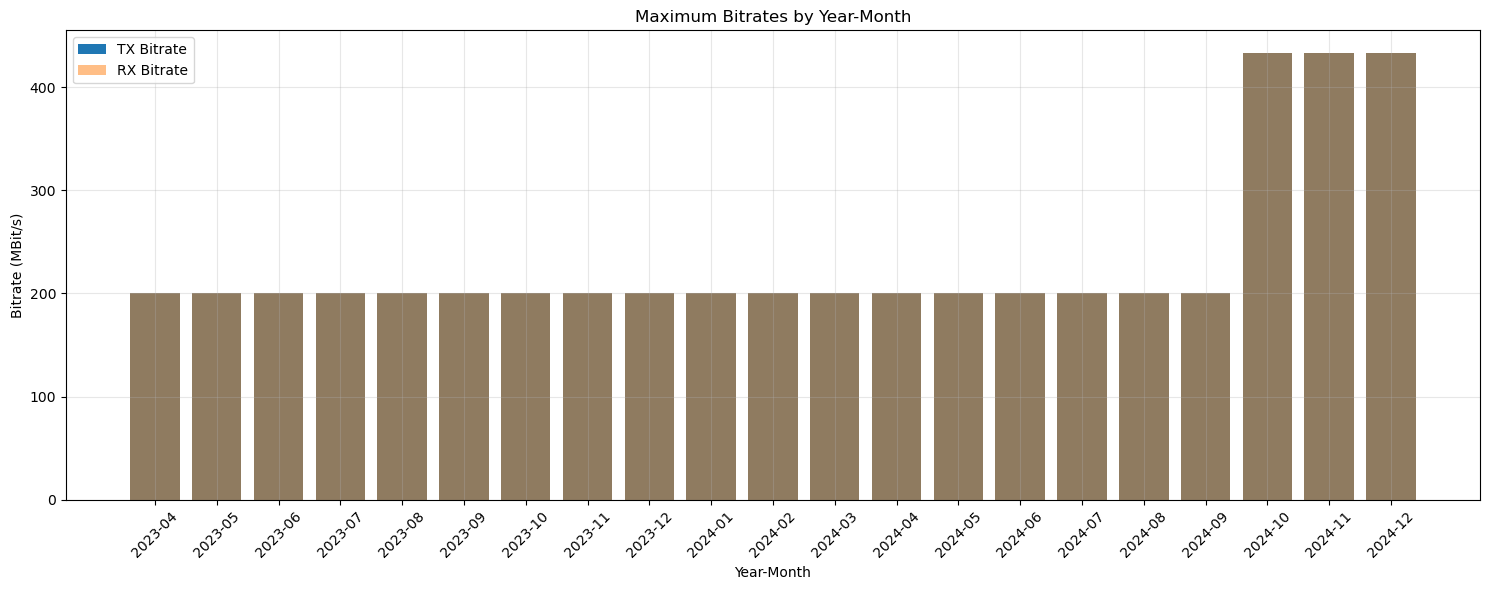


Chronological Averages:
   year_month  tx_bitrate (MBit/s)  rx_bitrate (MBit/s)
0     2023-04                200.0                200.0
1     2023-05                200.0                200.0
2     2023-06                200.0                200.0
3     2023-07                200.0                200.0
4     2023-08                200.0                200.0
5     2023-09                200.0                200.0
6     2023-10                200.0                200.0
7     2023-11                200.0                200.0
8     2023-12                200.0                200.0
9     2024-01                200.0                200.0
10    2024-02                200.0                200.0
11    2024-03                200.0                200.0
12    2024-04                200.0                200.0
13    2024-05                200.0                200.0
14    2024-06                200.0                200.0
15    2024-07                200.0                200.0
16    2024-08          

In [22]:
# Create year-month column and ensure proper chronological ordering
wifistats_df['year_month'] = pd.to_datetime(wifistats_df['time']).dt.strftime('%Y-%m')

# Calculate maximum bitrates for each year-month
chronological_avg = wifistats_df.groupby('year_month').agg({
    'tx_bitrate (MBit/s)': 'max',
    'rx_bitrate (MBit/s)': 'max'
}).reset_index()

# Sort chronologically
chronological_avg = chronological_avg.sort_values('year_month')

plt.figure(figsize=(15, 6))
plt.bar(range(len(chronological_avg)), chronological_avg['tx_bitrate (MBit/s)'], label='TX Bitrate')
plt.bar(range(len(chronological_avg)), chronological_avg['rx_bitrate (MBit/s)'], label='RX Bitrate', alpha=0.5)

# Set x-axis labels
plt.xticks(range(len(chronological_avg)), chronological_avg['year_month'], rotation=45)

plt.title('Maximum Bitrates by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Bitrate (MBit/s)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nChronological Averages:")
print(chronological_avg)

This visualization suggests there was likely a network upgrade or reconfiguration in October 2024 that more than doubled the maximum bitrate capacity from 200 MBit/s to 433.3 MBit/s. The fact that both TX and RX rates changed simultaneously and maintain the same values indicates this was a symmetric upgrade affecting both upload and download speeds.


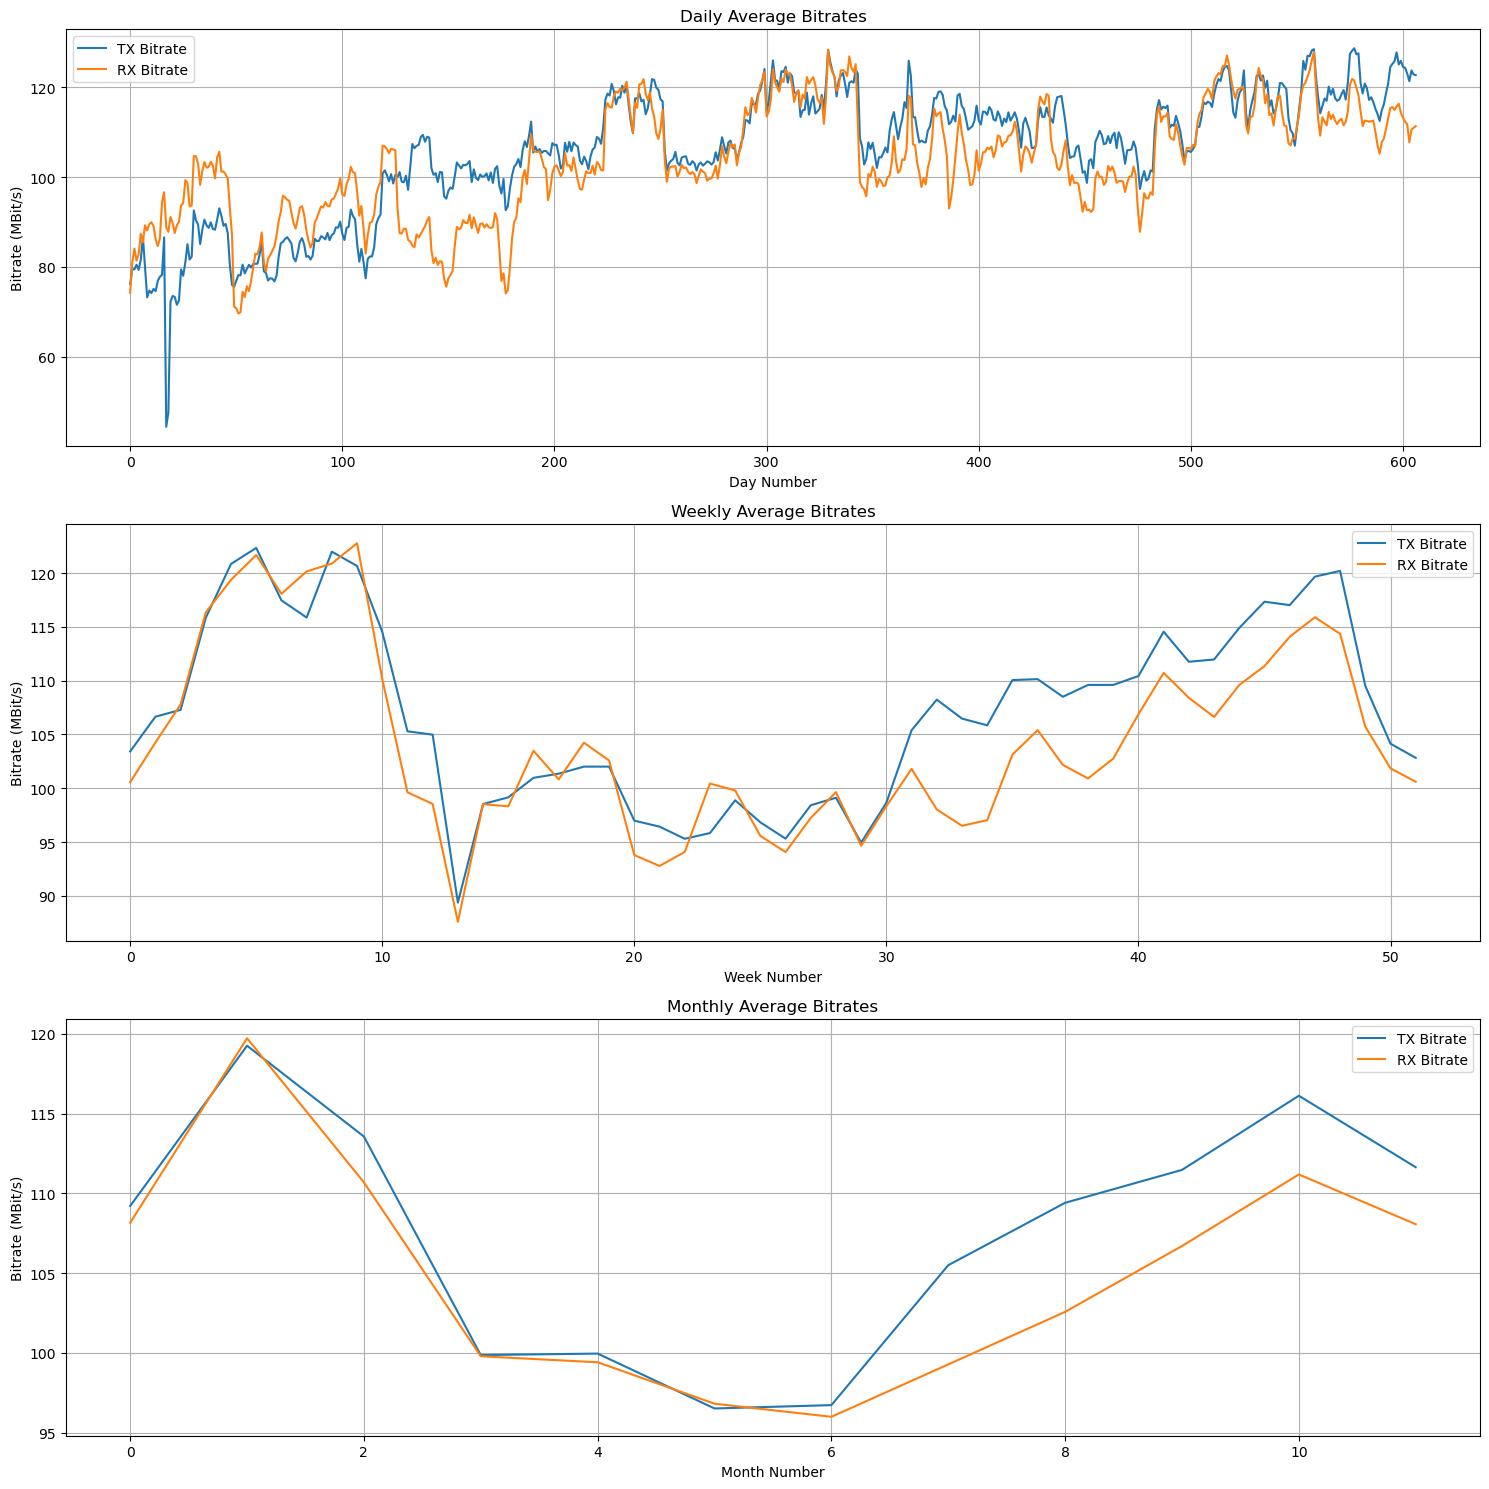


Daily Averages (first few rows):
         date  tx_bitrate (MBit/s)  rx_bitrate (MBit/s)
0  2023-04-06            76.281456            74.244505
1  2023-04-07            79.504243            81.077331
2  2023-04-08            79.486441            84.077105
3  2023-04-09            80.505842            81.397760
4  2023-04-10            79.357252            82.846354

Weekly Averages:
   week  tx_bitrate (MBit/s)  rx_bitrate (MBit/s)
0     1           103.422395           100.559169
1     2           106.649630           104.247159
2     3           107.289200           107.786335
3     4           115.843752           116.346256
4     5           120.852267           119.371781

Monthly Averages:
   month  tx_bitrate (MBit/s)  rx_bitrate (MBit/s)
0      1           109.211447           108.156421
1      2           119.251480           119.719195
2      3           113.561224           110.689899
3      4            99.868393            99.792957
4      5            99.961511         

In [23]:
# Create different time-based aggregations
wifistats_df['time'] = pd.to_datetime(wifistats_df['time'])
wifistats_df['date'] = wifistats_df['time'].dt.date
wifistats_df['month'] = wifistats_df['time'].dt.month
wifistats_df['week'] = wifistats_df['time'].dt.isocalendar().week

# Calculate averages at different time scales
daily_avg = wifistats_df.groupby('date').agg({
    'tx_bitrate (MBit/s)': 'mean',
    'rx_bitrate (MBit/s)': 'mean'
}).reset_index()

weekly_avg = wifistats_df.groupby(['week']).agg({
    'tx_bitrate (MBit/s)': 'mean',
    'rx_bitrate (MBit/s)': 'mean'
}).reset_index()

monthly_avg = wifistats_df.groupby(['month']).agg({
    'tx_bitrate (MBit/s)': 'mean',
    'rx_bitrate (MBit/s)': 'mean'
}).reset_index()

# Create visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Daily plot
ax1.plot(range(len(daily_avg)), daily_avg['tx_bitrate (MBit/s)'], label='TX Bitrate')
ax1.plot(range(len(daily_avg)), daily_avg['rx_bitrate (MBit/s)'], label='RX Bitrate')
ax1.set_title('Daily Average Bitrates')
ax1.set_xlabel('Day Number')
ax1.set_ylabel('Bitrate (MBit/s)')
ax1.legend()
ax1.grid(True)

# Weekly plot
ax2.plot(range(len(weekly_avg)), weekly_avg['tx_bitrate (MBit/s)'], label='TX Bitrate')
ax2.plot(range(len(weekly_avg)), weekly_avg['rx_bitrate (MBit/s)'], label='RX Bitrate')
ax2.set_title('Weekly Average Bitrates')
ax2.set_xlabel('Week Number')
ax2.set_ylabel('Bitrate (MBit/s)')
ax2.legend()
ax2.grid(True)

# Monthly plot
ax3.plot(range(len(monthly_avg)), monthly_avg['tx_bitrate (MBit/s)'], label='TX Bitrate')
ax3.plot(range(len(monthly_avg)), monthly_avg['rx_bitrate (MBit/s)'], label='RX Bitrate')
ax3.set_title('Monthly Average Bitrates')
ax3.set_xlabel('Month Number')
ax3.set_ylabel('Bitrate (MBit/s)')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

# Print the averages
print("\nDaily Averages (first few rows):")
print(daily_avg.head())
print("\nWeekly Averages:")
print(weekly_avg.head())
print("\nMonthly Averages:")
print(monthly_avg.head())

#How I calculated the averages:
1. Daily Averages:
We calculated the average bitrate for each day by averaging the TX and RX rates for that day.
2. Weekly Averages:
We calculated the average bitrate for each week by averaging the TX and RX rates for all days in that week.
3. Monthly Averages:
We calculated the average bitrate for each month by averaging the TX and RX rates for all days in that month.

#How I interpreted the averages:

Trend Analysis:
The daily averages show fluctuations (from ~76 to ~84 MBit/s)
Weekly averages show an upward trend (from ~103 to ~120 MBit/s)
Monthly averages show cyclical patterns (peaks in February at ~119 MBit/s, drops in April/May to ~99 MBit/s)
Predictive Value:
We could predict future bitrates based on these patterns
This could help with:
Network capacity planning
Identifying when upgrades might be needed
Scheduling high-bandwidth activities during typically high-performance periods
Pattern Recognition:
There appears to be correlation between TX and RX rates
Weekly progression shows consistent increases (Week 1: ~103, Week 5: ~120)
Monthly patterns suggest seasonal or cyclical behavior
4. Relationship Analysis:
We could model the relationship between:
Time of year and performance
TX and RX rates (they seem closely related)
Day of week and performance levels
A regression model could help:
Quantify these relationships
Make predictions about future performance
Identify significant factors affecting network performance
Determine if the patterns we see are statistically significant
Would you like to explore any specific aspect of these relationships through regression analysis?




WiFi Standards
Most modern WiFi networks use 802.11n or 802.11ac standards
Theoretical maximum speeds:
802.11n: up to 300 Mbit/s
802.11ac: up to 1300 Mbit/s
Real-world speeds are typically much lower due to various factors
Common Factors Affecting Speed
Distance from router
Physical obstacles (walls, furniture)
Interference from other devices
Network congestion
Time of day (peak vs off-peak usage)
Your Data Context
The 80-120 MBit/s range is actually quite stable for real-world WiFi performance
These speeds are good enough for:
HD video streaming (needs ~5-8 MBit/s)
Video conferencing (needs ~1.5-4 MBit/s)
Large file downloads
Most other common internet activities
4. Consistency
The fact that your fluctuations stay within a relatively narrow band (80-120 MBit/s) suggests a stable network with normal variations rather than problematic inconsistency, which would show more extreme swings.

/var/folders/bm/dh8z1y295zx4278nbfwzcvz40000gn/T/ipykernel_92384/3330991194.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_features['month'] = wifistats_df['time'].dt.month
/var/folders/bm/dh8z1y295zx4278nbfwzcvz40000gn/T/ipykernel_92384/3330991194.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_features['month'] = wifistats_df['time'].dt.month
/Users/freddiekiessling/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init


Cluster Characteristics:

Cluster 0:
Average TX Bitrate: 180.5841938637686
Average RX Bitrate: 186.0563604767475
Most common days: [0]
Most common hours: [11]
Most common months: [10]

Cluster 1:
Average TX Bitrate: 62.08429026883599
Average RX Bitrate: 53.8569193217736
Most common days: [3]
Most common hours: [0]
Most common months: [8]

Cluster 2:
Average TX Bitrate: 61.81798204763771
Average RX Bitrate: 53.99413904915586
Most common days: [5]
Most common hours: [22]
Most common months: [8]


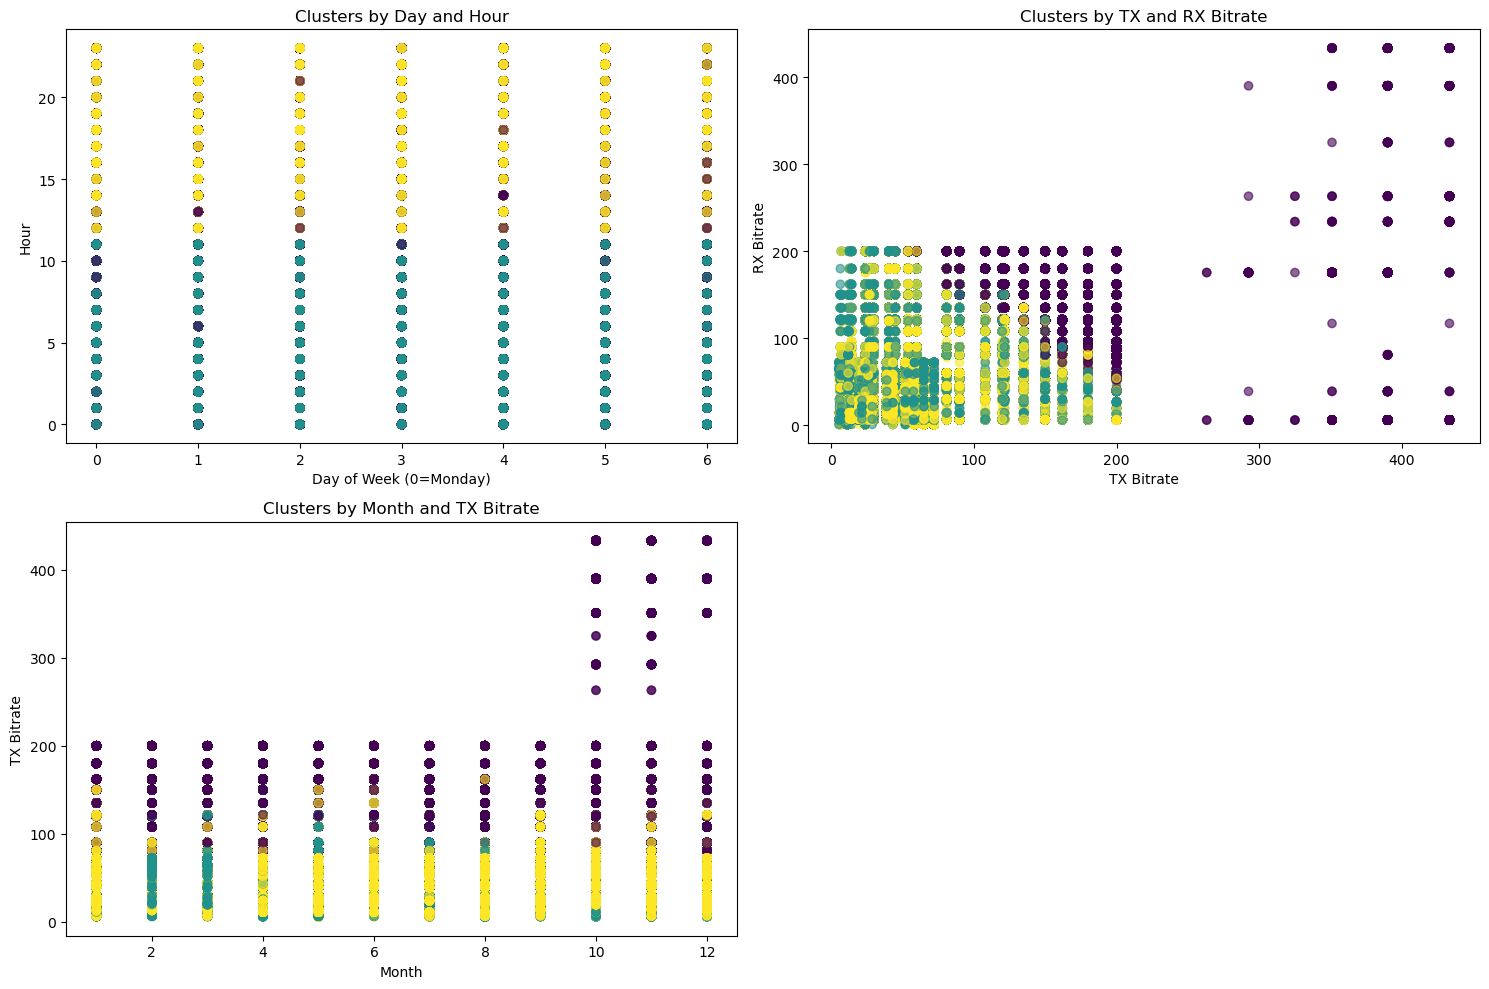

In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# First, create the necessary time-based columns
wifistats_df['day_of_week'] = wifistats_df['time'].dt.dayofweek  # 0=Monday, 6=Sunday
wifistats_df['hour'] = wifistats_df['time'].dt.hour

# Then proceed with the clustering code
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare data for clustering
cluster_features = wifistats_df[['day_of_week', 'hour', 'tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)']]
cluster_features['month'] = wifistats_df['time'].dt.month

# Prepare data for clustering
cluster_features = wifistats_df[['day_of_week', 'hour', 'tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)']]
cluster_features['month'] = wifistats_df['time'].dt.month

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

# Try different numbers of clusters (k=3 to start, but we can adjust)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels back to original data
wifistats_df['cluster'] = cluster_labels

# Visualize clusters
plt.figure(figsize=(15, 10))

# Plot 1: Day of Week vs Hour colored by cluster
plt.subplot(2, 2, 1)
plt.scatter(wifistats_df['day_of_week'], wifistats_df['hour'], 
            c=cluster_labels, cmap='viridis', alpha=0.6)
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Hour')
plt.title('Clusters by Day and Hour')

# Plot 2: TX vs RX Bitrate colored by cluster
plt.subplot(2, 2, 2)
plt.scatter(wifistats_df['tx_bitrate (MBit/s)'], 
           wifistats_df['rx_bitrate (MBit/s)'], 
           c=cluster_labels, cmap='viridis', alpha=0.6)
plt.xlabel('TX Bitrate')
plt.ylabel('RX Bitrate')
plt.title('Clusters by TX and RX Bitrate')

# Plot 3: Month vs Bitrate colored by cluster
plt.subplot(2, 2, 3)
plt.scatter(wifistats_df['time'].dt.month, 
           wifistats_df['tx_bitrate (MBit/s)'], 
           c=cluster_labels, cmap='viridis', alpha=0.6)
plt.xlabel('Month')
plt.ylabel('TX Bitrate')
plt.title('Clusters by Month and TX Bitrate')

# Print cluster characteristics
print("\nCluster Characteristics:")
for i in range(n_clusters):
    cluster_data = wifistats_df[wifistats_df['cluster'] == i]
    print(f"\nCluster {i}:")
    print("Average TX Bitrate:", cluster_data['tx_bitrate (MBit/s)'].mean())
    print("Average RX Bitrate:", cluster_data['rx_bitrate (MBit/s)'].mean())
    print("Most common days:", cluster_data['day_of_week'].mode().values)
    print("Most common hours:", cluster_data['hour'].mode().values)
    print("Most common months:", cluster_data['time'].dt.month.mode().values)

plt.tight_layout()
plt.show()

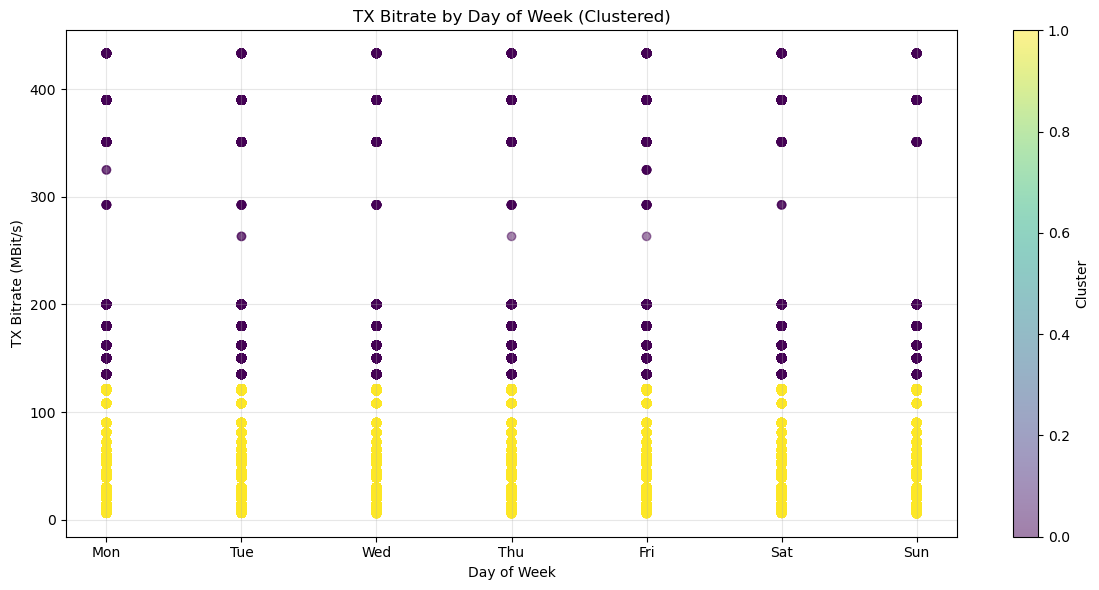

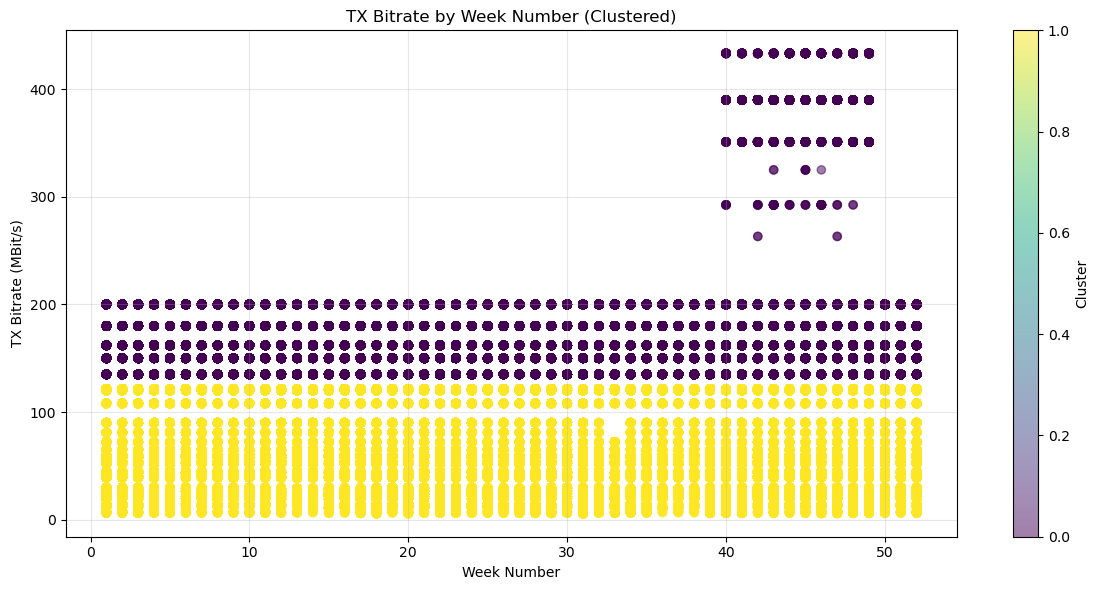

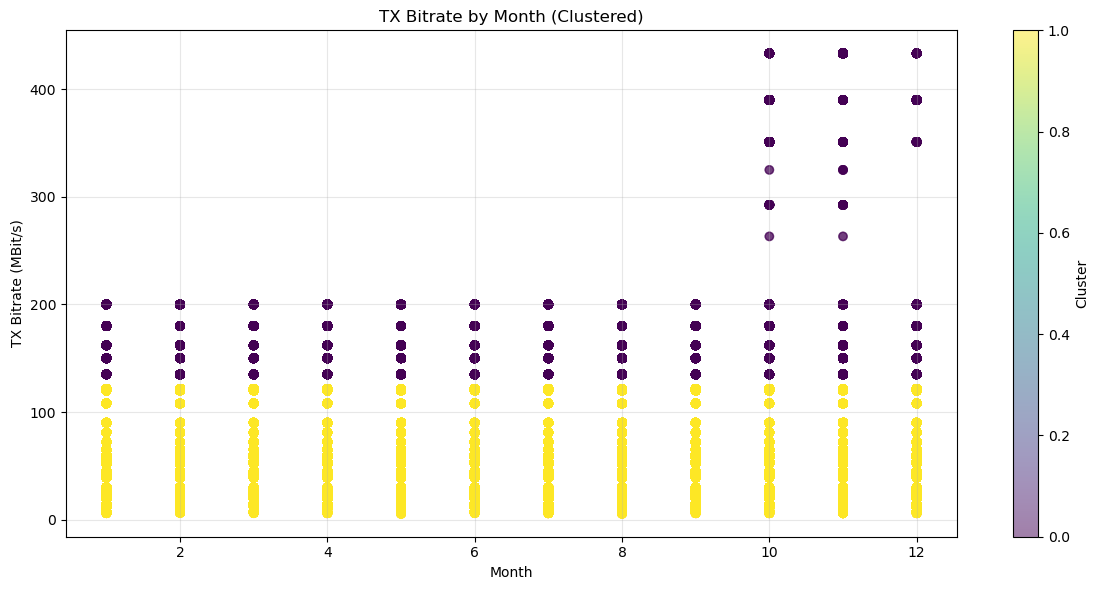


Clustering by Day of Week:

Cluster 0:
Average TX Bitrate: 182.25
Number of points: 1745516

Cluster 1:
Average TX Bitrate: 61.93
Number of points: 2927642

Clustering by Week:

Cluster 0:
Average TX Bitrate: 182.25
Number of points: 1745516

Cluster 1:
Average TX Bitrate: 61.93
Number of points: 2927642

Clustering by Month:

Cluster 0:
Average TX Bitrate: 182.25
Number of points: 1745516

Cluster 1:
Average TX Bitrate: 61.93
Number of points: 2927642


In [39]:
# First, let's create time-based features
wifistats_df['day_of_week'] = wifistats_df['time'].dt.dayofweek  # 0=Monday, 6=Sunday
wifistats_df['week'] = wifistats_df['time'].dt.isocalendar().week
wifistats_df['month'] = wifistats_df['time'].dt.month

# Create three separate K-means analyses
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Function to perform clustering and plotting
def cluster_and_plot(data, time_feature, feature_name):
    # Prepare data for clustering
    X = np.array(list(zip(data[time_feature], data['tx_bitrate (MBit/s)'])))
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform K-means
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Create plot
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(data[time_feature], 
                         data['tx_bitrate (MBit/s)'],
                         c=clusters,
                         cmap='viridis',
                         alpha=0.5)
    
    plt.xlabel(feature_name)
    plt.ylabel('TX Bitrate (MBit/s)')
    plt.title(f'TX Bitrate by {feature_name} (Clustered)')
    plt.colorbar(scatter, label='Cluster')
    
    if feature_name == 'Day of Week':
        plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return clusters

# Create three different clusterings
day_clusters = cluster_and_plot(wifistats_df, 'day_of_week', 'Day of Week')
week_clusters = cluster_and_plot(wifistats_df, 'week', 'Week Number')
month_clusters = cluster_and_plot(wifistats_df, 'month', 'Month')

# Print summary statistics for each clustering
for time_period, clusters in [('Day of Week', day_clusters), 
                            ('Week', week_clusters), 
                            ('Month', month_clusters)]:
    print(f"\nClustering by {time_period}:")
    for cluster in [0, 1]:
        mask = clusters == cluster
        print(f"\nCluster {cluster}:")
        print(f"Average TX Bitrate: {wifistats_df.loc[mask, 'tx_bitrate (MBit/s)'].mean():.2f}")
        print(f"Number of points: {mask.sum()}")

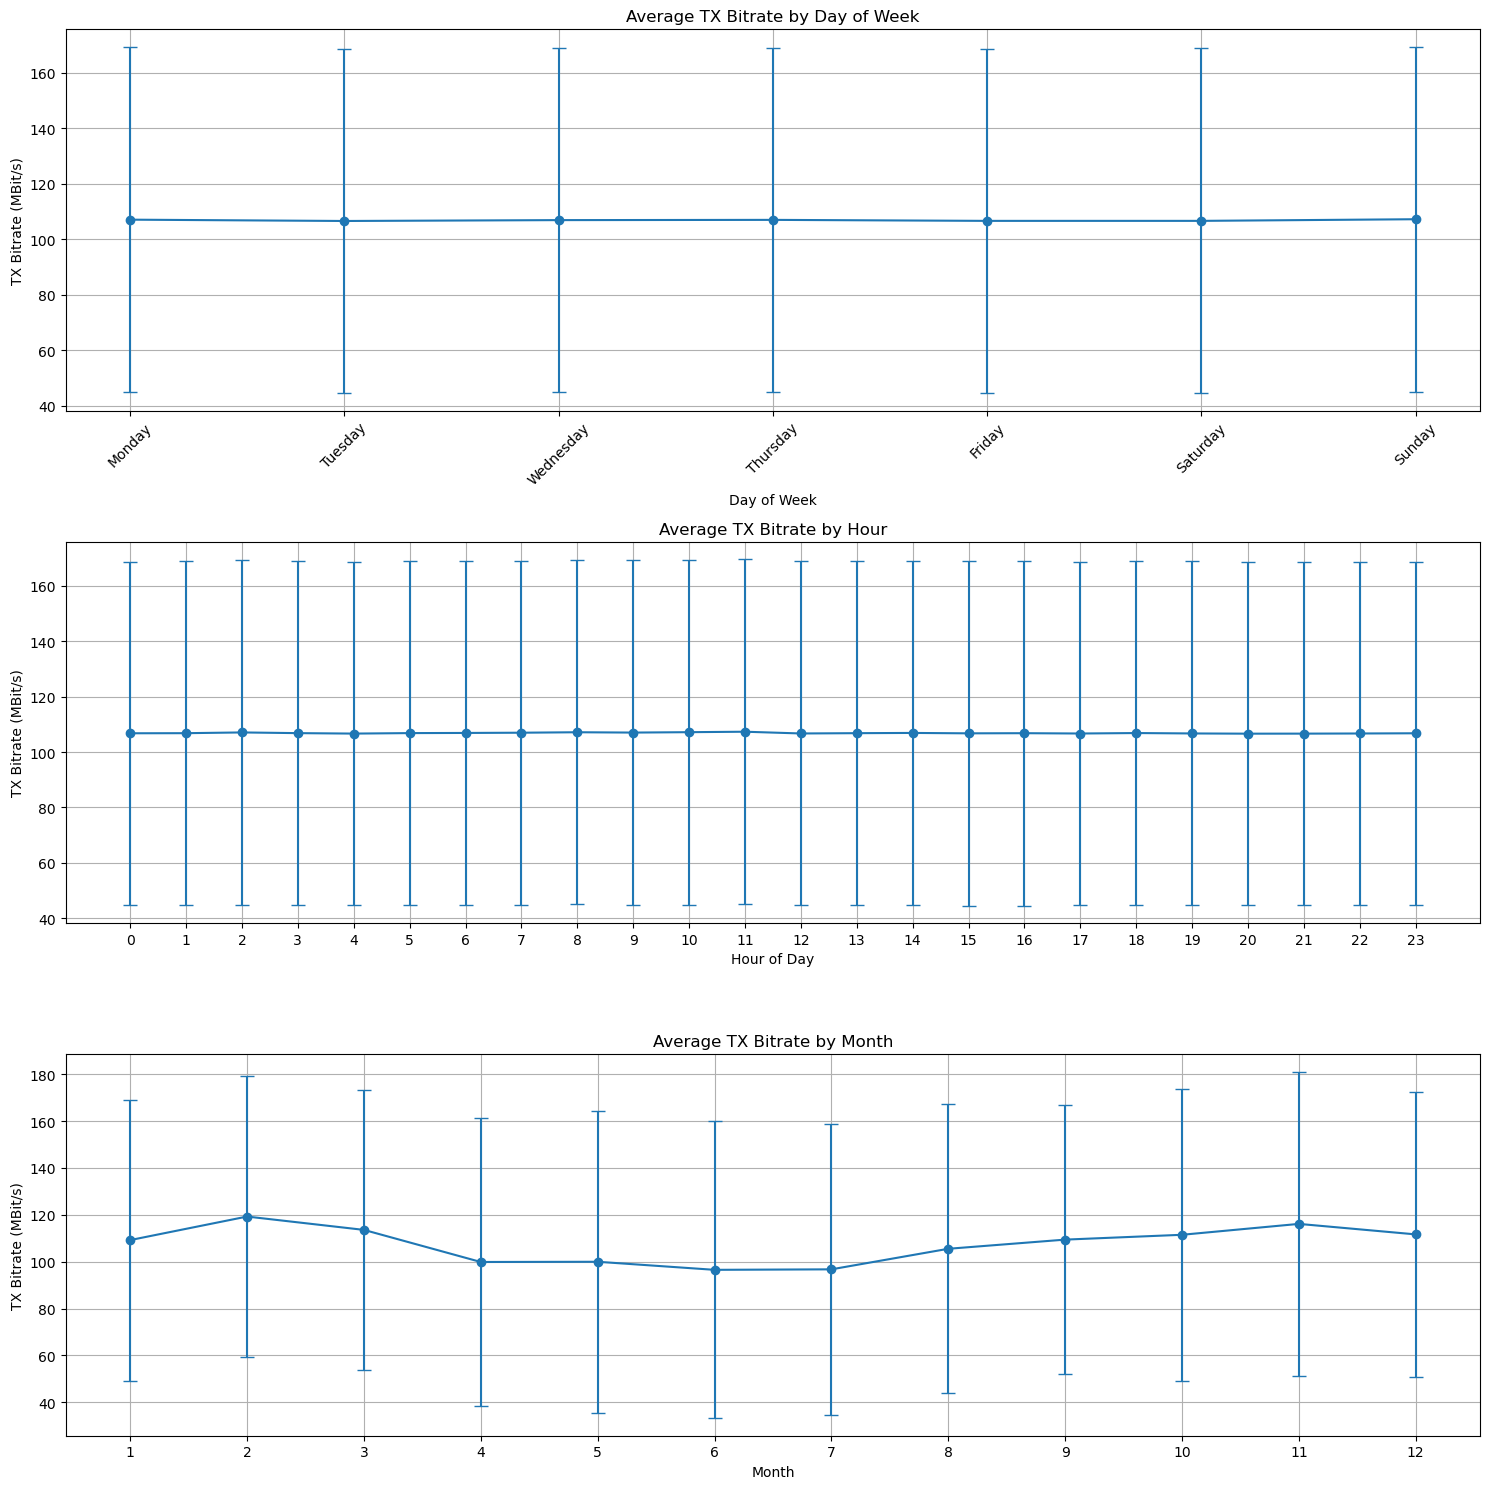


Daily Statistics:
  day_of_week        mean        std
1      Monday  107.075606  62.272561
5     Tuesday  106.600479  61.906037
6   Wednesday  106.913420  62.067626
4    Thursday  107.001421  62.045230
0      Friday  106.639069  62.079167
2    Saturday  106.642895  62.135975
3      Sunday  107.232838  62.206167

Hourly Statistics:
    hour        mean        std
0      0  106.791512  61.960227
1      1  106.825489  62.027955
2      2  107.095669  62.317450
3      3  106.843768  62.012034
4      4  106.678717  61.831559
5      5  106.854749  62.004842
6      6  106.910737  62.073380
7      7  106.996038  62.086980
8      8  107.162541  62.151724
9      9  107.044662  62.158750
10    10  107.188482  62.255506
11    11  107.353269  62.304727
12    12  106.721767  62.121265
13    13  106.829344  62.183020
14    14  106.914686  62.273657
15    15  106.770318  62.304091
16    16  106.821519  62.259444
17    17  106.709193  62.100323
18    18  106.873931  62.089245
19    19  106.729144  62.

In [41]:
# Create daily, weekly, and monthly averages
wifistats_df['time'] = pd.to_datetime(wifistats_df['time'])
wifistats_df['day_of_week'] = wifistats_df['time'].dt.day_name()
wifistats_df['hour'] = wifistats_df['time'].dt.hour
wifistats_df['month'] = wifistats_df['time'].dt.month

# 1. Daily patterns (by day of week)
daily_avg = wifistats_df.groupby('day_of_week')['tx_bitrate (MBit/s)'].agg(['mean', 'std']).reset_index()
# Ensure days are in correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg['day_of_week'] = pd.Categorical(daily_avg['day_of_week'], categories=day_order, ordered=True)
daily_avg = daily_avg.sort_values('day_of_week')

# 2. Hourly patterns
hourly_avg = wifistats_df.groupby('hour')['tx_bitrate (MBit/s)'].agg(['mean', 'std']).reset_index()

# 3. Monthly patterns
monthly_avg = wifistats_df.groupby('month')['tx_bitrate (MBit/s)'].agg(['mean', 'std']).reset_index()

# Create plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Daily patterns
ax1.errorbar(daily_avg['day_of_week'], daily_avg['mean'], yerr=daily_avg['std'], 
            fmt='o-', capsize=5)
ax1.set_title('Average TX Bitrate by Day of Week')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('TX Bitrate (MBit/s)')
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# Hourly patterns
ax2.errorbar(hourly_avg['hour'], hourly_avg['mean'], yerr=hourly_avg['std'], 
            fmt='o-', capsize=5)
ax2.set_title('Average TX Bitrate by Hour')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('TX Bitrate (MBit/s)')
ax2.grid(True)
ax2.set_xticks(range(24))

# Monthly patterns
ax3.errorbar(monthly_avg['month'], monthly_avg['mean'], yerr=monthly_avg['std'], 
            fmt='o-', capsize=5)
ax3.set_title('Average TX Bitrate by Month')
ax3.set_xlabel('Month')
ax3.set_ylabel('TX Bitrate (MBit/s)')
ax3.grid(True)
ax3.set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nDaily Statistics:")
print(daily_avg)
print("\nHourly Statistics:")
print(hourly_avg)
print("\nMonthly Statistics:")
print(monthly_avg)

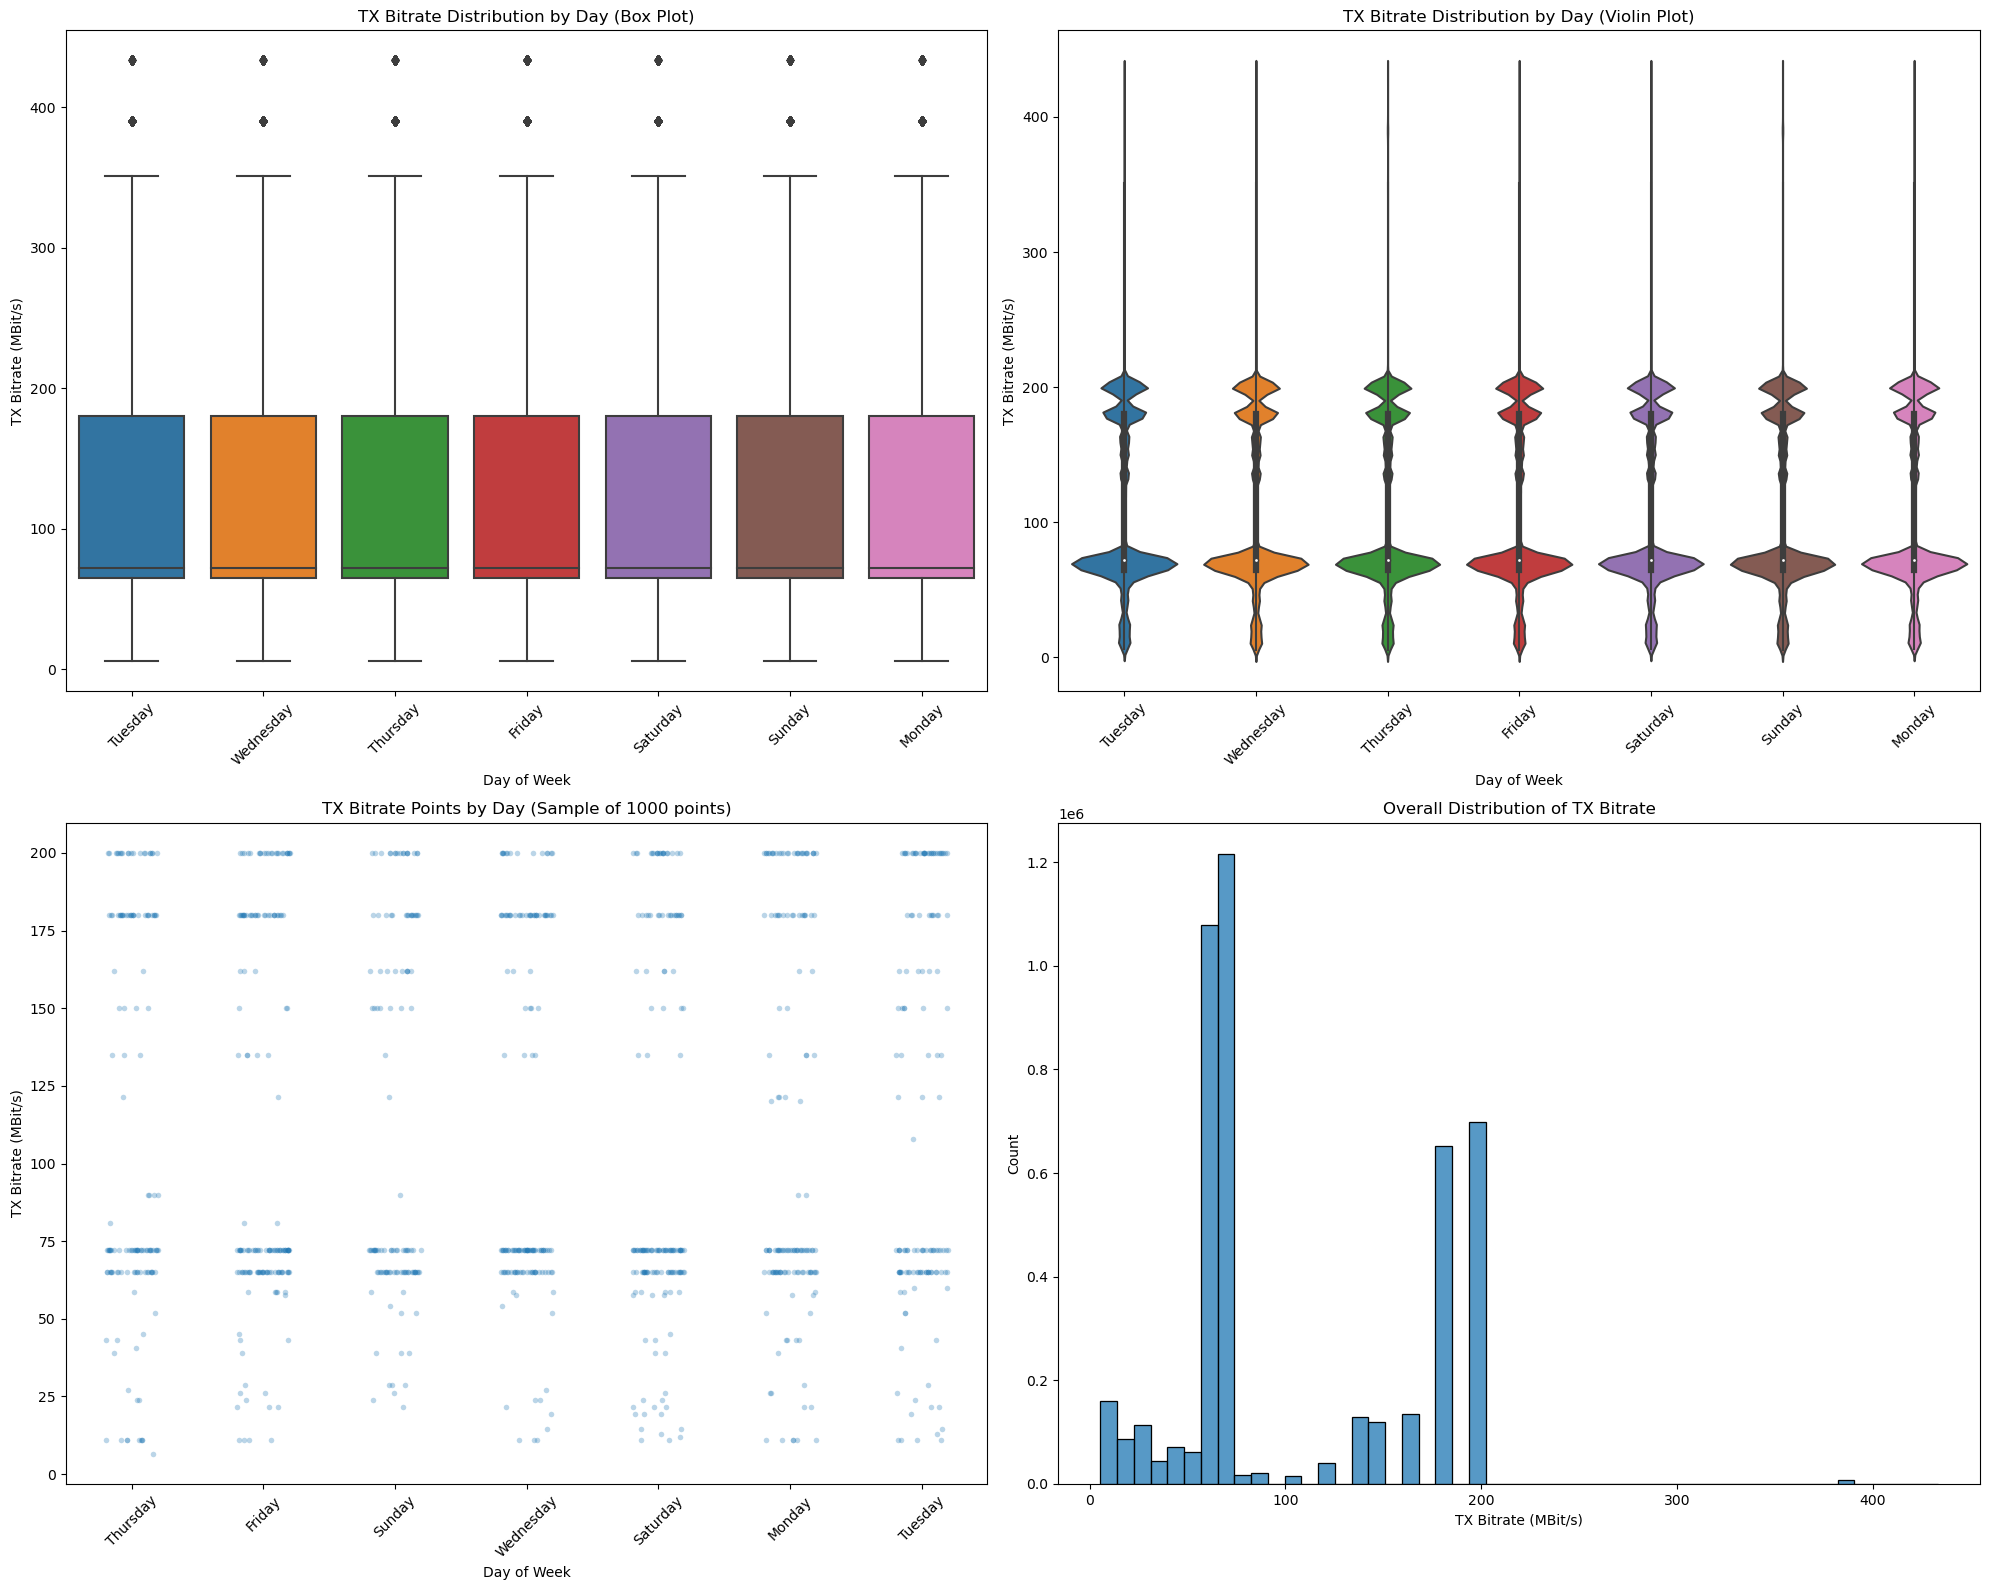


Detailed Statistics by Day:
                count        mean        std  min   25%   50%    75%    max
day_of_week                                                                
Friday       668814.0  106.639069  62.079167  5.5  65.0  72.2  180.0  433.3
Monday       673390.0  107.075606  62.272561  6.0  65.0  72.2  180.0  433.3
Saturday     673226.0  106.642895  62.135975  6.0  65.0  72.2  180.0  433.3
Sunday       663871.0  107.232838  62.206167  5.5  65.0  72.2  180.0  433.3
Thursday     670066.0  107.001421  62.045230  5.5  65.0  72.2  180.0  433.3
Tuesday      666860.0  106.600479  61.906037  6.0  65.0  72.2  180.0  433.3
Wednesday    656931.0  106.913420  62.067626  5.5  65.0  72.2  180.0  433.3

Most Common TX Bitrate Values:
72.2     1214883
65.0      935052
200.0     697594
180.0     652580
11.0      146296
Name: tx_bitrate (MBit/s), dtype: int64


In [42]:
# Create subplots for different visualization types
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Box Plot
sns.boxplot(data=wifistats_df, x='day_of_week', y='tx_bitrate (MBit/s)', ax=ax1)
ax1.set_title('TX Bitrate Distribution by Day (Box Plot)')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('TX Bitrate (MBit/s)')
ax1.tick_params(axis='x', rotation=45)

# 2. Violin Plot
sns.violinplot(data=wifistats_df, x='day_of_week', y='tx_bitrate (MBit/s)', ax=ax2)
ax2.set_title('TX Bitrate Distribution by Day (Violin Plot)')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('TX Bitrate (MBit/s)')
ax2.tick_params(axis='x', rotation=45)

# 3. Strip Plot with some jittering (showing actual points)
sns.stripplot(data=wifistats_df.sample(n=1000), x='day_of_week', y='tx_bitrate (MBit/s)', 
             jitter=0.2, size=4, alpha=0.3, ax=ax3)
ax3.set_title('TX Bitrate Points by Day (Sample of 1000 points)')
ax3.set_xlabel('Day of Week')
ax3.set_ylabel('TX Bitrate (MBit/s)')
ax3.tick_params(axis='x', rotation=45)

# 4. Histogram for overall distribution
sns.histplot(data=wifistats_df, x='tx_bitrate (MBit/s)', bins=50, ax=ax4)
ax4.set_title('Overall Distribution of TX Bitrate')
ax4.set_xlabel('TX Bitrate (MBit/s)')
ax4.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nDetailed Statistics by Day:")
print(wifistats_df.groupby('day_of_week')['tx_bitrate (MBit/s)'].describe())

# Calculate the most common values
print("\nMost Common TX Bitrate Values:")
print(wifistats_df['tx_bitrate (MBit/s)'].value_counts().head())

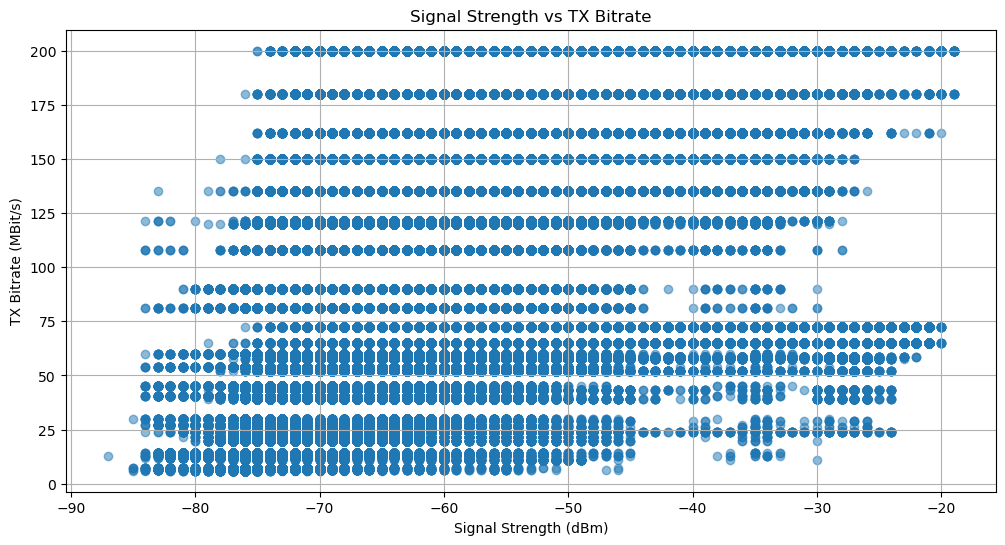

In [26]:
# Create a simple correlation between signal strength and performance metrics
plt.figure(figsize=(12, 6))
plt.scatter(df['signal (dBm)'], df['tx_bitrate (MBit/s)'], alpha=0.5)
plt.xlabel('Signal Strength (dBm)')
plt.ylabel('TX Bitrate (MBit/s)')
plt.title('Signal Strength vs TX Bitrate')
plt.grid(True)
plt.show()

# Latency Analysis

In [27]:
# Calculate average latency metrics per device
latency_analysis = df.groupby('label').agg({
    'min_ping_rtt (ms)': 'mean',
    'avg_ping_rtt (ms)': 'mean',
    'max_ping_rtt (ms)': 'mean'
}).round(2)

# Sort by average ping
print("Devices sorted by average ping time:")
print(latency_analysis.sort_values('avg_ping_rtt (ms)'))

Devices sorted by average ping time:
                         min_ping_rtt (ms)  avg_ping_rtt (ms)  \
label                                                           
raspi-e4:5f:01:72:a2:eb               1.43               2.03   
raspi-e4:5f:01:75:6b:2c               1.43               2.05   
raspi-e4:5f:01:56:d9:a3               1.49               2.16   
raspi-e4:5f:01:56:d8:f3               2.16               3.41   
raspi-e4:5f:01:75:54:04               3.29               4.45   
raspi-e4:5f:01:a7:b1:e2               3.30               4.53   
raspi-e4:5f:01:6f:ed:f3               3.27               4.54   
raspi-e4:5f:01:a0:34:a8               2.75               4.68   
raspi-e4:5f:01:a0:34:a5               3.32               4.75   
raspi-e4:5f:01:a0:50:5f               3.45               4.79   
raspi-e4:5f:01:a7:b1:af               3.38               4.85   
raspi-e4:5f:01:78:6f:2e               3.46               4.87   
raspi-e4:5f:01:8d:ca:12               3.40           

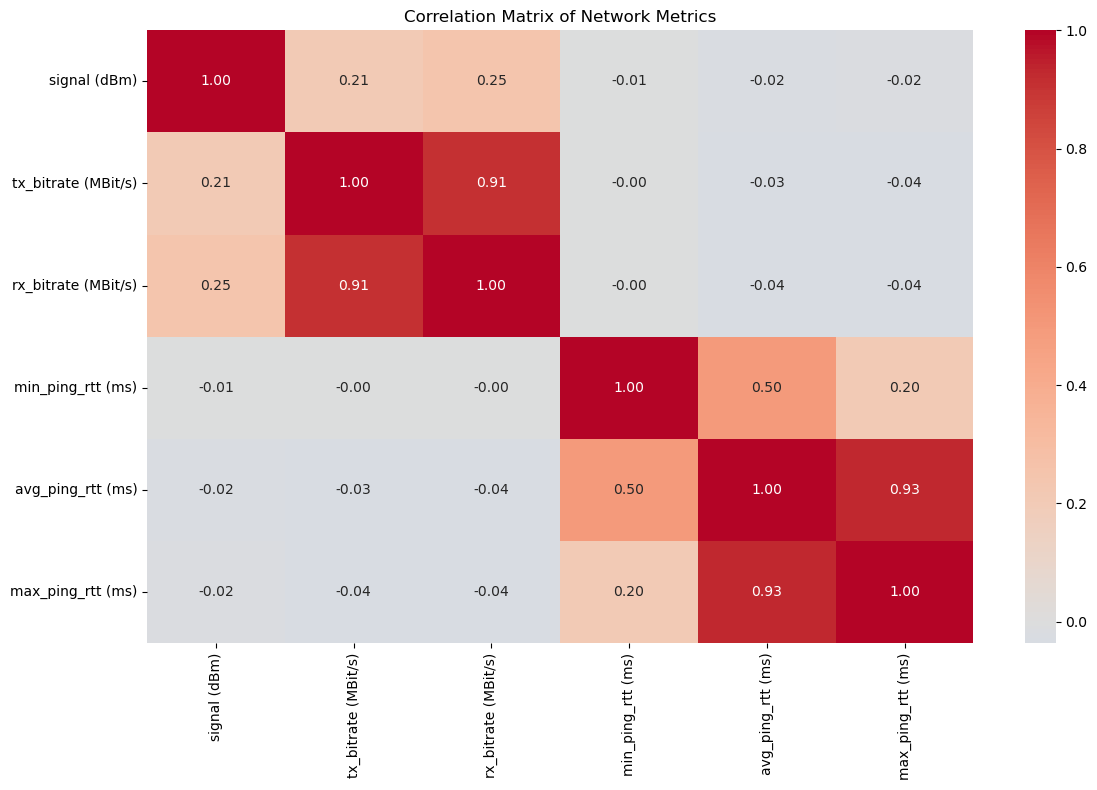

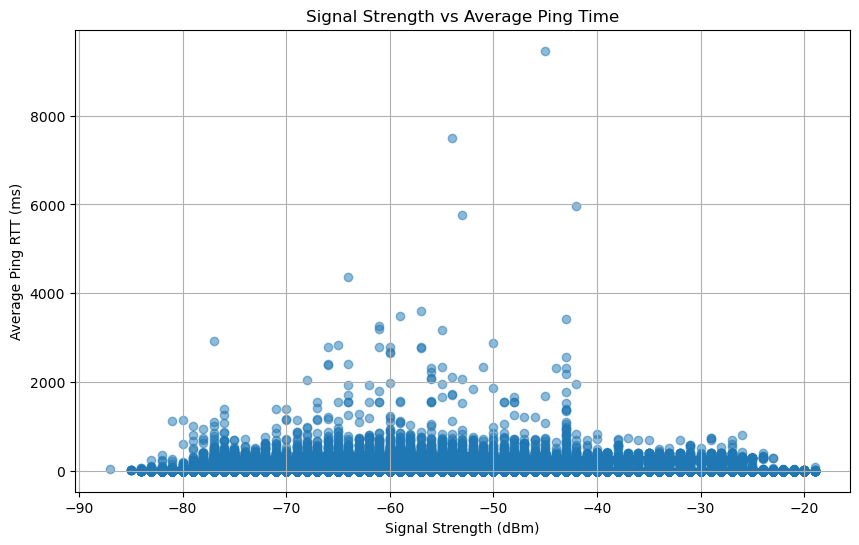


Correlations with Average Ping Time:
avg_ping_rtt (ms)      1.000000
max_ping_rtt (ms)      0.931884
min_ping_rtt (ms)      0.498135
signal (dBm)          -0.021442
tx_bitrate (MBit/s)   -0.034300
rx_bitrate (MBit/s)   -0.035596
Name: avg_ping_rtt (ms), dtype: float64


In [28]:
# Calculate correlations between ping times and other metrics
correlation_metrics = ['signal (dBm)', 'tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)', 
                      'min_ping_rtt (ms)', 'avg_ping_rtt (ms)', 'max_ping_rtt (ms)']

# Create correlation matrix
correlation_matrix = df[correlation_metrics].corr()

# Create visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Network Metrics')
plt.tight_layout()
plt.show()

# Let's also look at the relationship between signal strength and average ping
plt.figure(figsize=(10, 6))
plt.scatter(df['signal (dBm)'], df['avg_ping_rtt (ms)'], alpha=0.5)
plt.xlabel('Signal Strength (dBm)')
plt.ylabel('Average Ping RTT (ms)')
plt.title('Signal Strength vs Average Ping Time')
plt.grid(True)
plt.show()

# Print summary of correlations with average ping
print("\nCorrelations with Average Ping Time:")
correlations_with_ping = correlation_matrix['avg_ping_rtt (ms)'].sort_values(ascending=False)
print(correlations_with_ping)

The correlation matrix reveals several key insights about the network's behavior: TX and RX bitrates show a very strong positive correlation (0.91), indicating they consistently rise and fall together, while ping time metrics (min, avg, max) are strongly correlated with each other (0.50-0.93) as expected. Interestingly, signal strength shows only weak positive correlations with bitrates (0.21-0.25) and negligible correlations with ping times (-0.01 to -0.02), suggesting that signal strength isn't the dominant factor in network performance. The near-zero correlations between bitrates and ping times (-0.00 to -0.04) indicate that latency operates independently of throughput, pointing to a well-designed network where high traffic doesn't significantly impact latency. These patterns suggest that while the network functions effectively with consistent bidirectional throughput and stable latency, factors beyond these measured metrics might be more influential in determining overall network performance.

The scatter plot and correlation data reveal interesting insights about the relationship between signal strength and network latency. Most ping times concentrate in the 0-1000ms range regardless of signal strength, with occasional outliers reaching up to ~9000ms across various signal strengths. The signal strength spans from -90 dBm (weaker) to -20 dBm (stronger), but notably shows almost no correlation with ping times (-0.021), suggesting that signal strength has minimal impact on latency. This is further supported by very weak negative correlations between bitrates and ping times (-0.034 to -0.036), while the strongest correlation exists between average and maximum ping times (0.93). These patterns indicate a well-designed, resilient network where latency remains stable regardless of signal strength, and performance is maintained consistently across different signal levels. The occasional latency spikes appear to be influenced by factors other than signal strength, pointing to effective network coverage and redundancy in the system's design.

# First  regression model attempt
super bad only explains 4% of the variance in tx_bitrate

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# First, let's check where our NaN values are
print("NaN values in each column:")
print(df[['signal (dBm)', 'min_ping_rtt (ms)', 'tx_bitrate (MBit/s)']].isna().sum())

# Clean the data by removing rows with NaN values
clean_df = df.dropna(subset=['signal (dBm)', 'min_ping_rtt (ms)', 'tx_bitrate (MBit/s)'])

# Choose your variables
X = clean_df[['signal (dBm)', 'min_ping_rtt (ms)']]  # predictors
y = clean_df['tx_bitrate (MBit/s)']  # target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Check performance
print("\nModel Results:")
print("R² score:", model.score(X_test, y_test))
print("Coefficients:", dict(zip(X.columns, model.coef_)))
print("Intercept:", model.intercept_)

NaN values in each column:
signal (dBm)            0
min_ping_rtt (ms)      61
tx_bitrate (MBit/s)     0
dtype: int64

Model Results:
R² score: 0.04215811143610815
Coefficients: {'signal (dBm)': 1.2784195663944513, 'min_ping_rtt (ms)': -0.005596799668225247}
Intercept: 183.1091844986277


# Analyzing results:
1. Data Quality:
No missing values in signal strength or tx_bitrate
61 missing values in min_ping_rtt (relatively small compared to total dataset)
We dropped these rows for our analysis
Model Performance:
R² score = 0.0422 (or about 4.22%)
This is a very low R² value, indicating our model explains only about 4% of the variance in tx_bitrate
This suggests these predictors aren't very effective at predicting tx_bitrate
Coefficients:
signal (dBm): 1.278
For each 1 dBm increase in signal strength, tx_bitrate increases by 1.278 MBit/s
This positive relationship makes sense but is quite weak
min_ping_rtt: -0.006
Very small negative effect: higher ping times slightly decrease tx_bitrate
Almost negligible impact
Intercept: 183.109
The baseline tx_bitrate when other variables are zero

# Second regression model attempt
# This one explains 82% of the variance in tx_bitrate


In [32]:
# Clean the data
clean_df = df.dropna(subset=['signal (dBm)', 'rx_bitrate (MBit/s)', 'tx_bitrate (MBit/s)'])

# Choose new variables
X = clean_df[['signal (dBm)', 'rx_bitrate (MBit/s)']]  # new predictors
y = clean_df['tx_bitrate (MBit/s)']  # same target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Check performance
print("\nModel Results:")
print("R² score:", model.score(X_test, y_test))
print("Coefficients:", dict(zip(X.columns, model.coef_)))
print("Intercept:", model.intercept_)


Model Results:
R² score: 0.8210694071683359
Coefficients: {'signal (dBm)': -0.11952284660053049, 'rx_bitrate (MBit/s)': 0.7776850007581335}
Intercept: 20.861872557798762


Model Performance:
R² score = 0.821 (or 82.1%)
This is dramatically better than our previous 4.2%
The model now explains about 82% of the variance in tx_bitrate, which is quite good
Coefficients:
rx_bitrate: 0.778
Strong positive relationship
For every 1 MBit/s increase in rx_bitrate, tx_bitrate increases by 0.778 MBit/s
This makes intuitive sense given their high correlation (0.91)
signal (dBm): -0.120
Small negative relationship
For each 1 dBm increase in signal strength, tx_bitrate decreases by 0.12 MBit/s
This is a very minor effect compared to rx_bitrate's influence
Intercept: 20.862
This is the baseline tx_bitrate when other variables are zero
This model is much more useful because:
It has strong predictive power (82.1% accuracy)
It shows rx_bitrate is the dominant predictor
It confirms signal strength has minimal impact on tx_bitrate

Worst performing days for each metric (based on averages):

packet_loss:
Worst day on average: Monday with average value: 1.22

connected_time (s):
Worst day on average: Friday with average value: 938266.43

tx_bitrate (MBit/s):
Worst day on average: Tuesday with average value: 112.12

rx_bitrate (MBit/s):
Worst day on average: Friday with average value: 108.7

min_ping_rtt (ms):
Worst day on average: Thursday with average value: 3.46

avg_ping_rtt (ms):
Worst day on average: Thursday with average value: 7.43

max_ping_rtt (ms):
Worst day on average: Thursday with average value: 16.94

mdev_ping_rtt (ms):
Worst day on average: Thursday with average value: 5.39



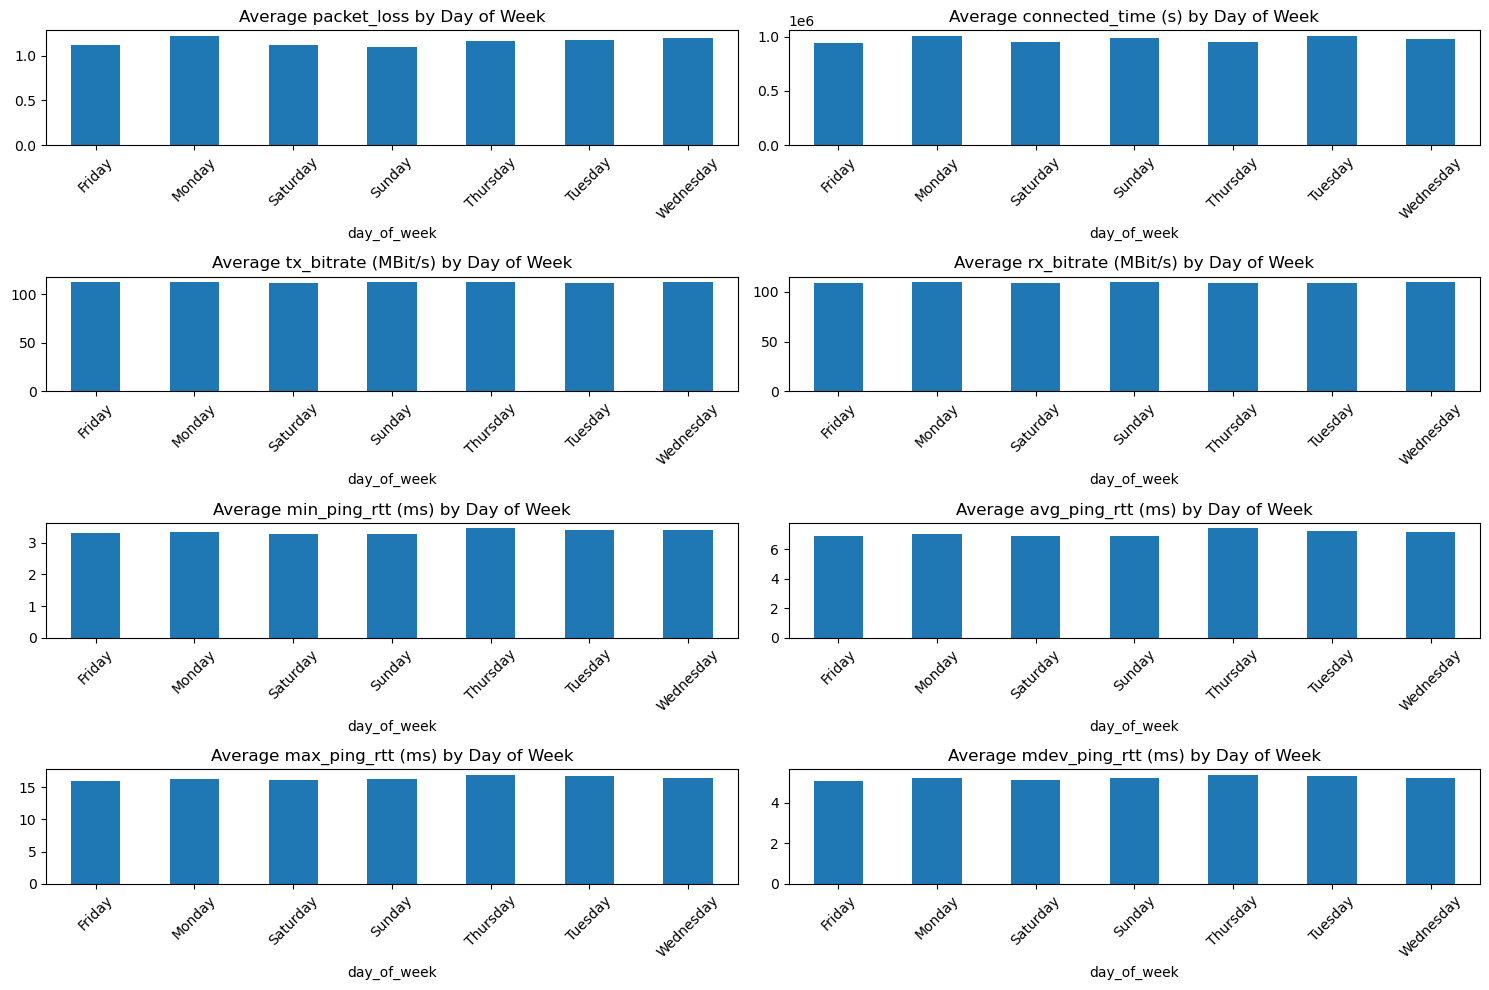

In [34]:
# Convert time column to datetime and extract day of week
df['day_of_week'] = pd.to_datetime(df['time']).dt.day_name()

# List of metrics to analyze
metrics = ['packet_loss', 'connected_time (s)', 'tx_bitrate (MBit/s)', 
          'rx_bitrate (MBit/s)', 'min_ping_rtt (ms)', 'avg_ping_rtt (ms)', 
          'max_ping_rtt (ms)', 'mdev_ping_rtt (ms)']

# Calculate daily averages for all metrics
daily_averages = df.groupby('day_of_week')[metrics].mean().round(2)

# Print worst day for each metric based on averages
print("Worst performing days for each metric (based on averages):\n")
for metric in metrics:
    if metric in ['tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)', 'connected_time (s)']:
        worst_day = daily_averages[metric].idxmin()  # Lowest average is worst
        worst_value = daily_averages[metric].min()
    else:
        worst_day = daily_averages[metric].idxmax()  # Highest average is worst
        worst_value = daily_averages[metric].max()
    
    print(f"{metric}:")
    print(f"Worst day on average: {worst_day} with average value: {worst_value}")
    print()

# Create visualization of daily averages
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(4, 2, i)
    daily_averages[metric].plot(kind='bar')
    plt.title(f'Average {metric} by Day of Week')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

Analyzing average network performance by day of the week reveals several notable patterns in the network's behavior. Thursday consistently shows the poorest latency metrics with highest average ping times (avg: 7.43ms, max: 16.94ms) and ping variation (mdev: 5.39ms), suggesting this might be a day of higher network congestion. Throughput metrics show their worst performance split between Tuesday (lowest tx_bitrate at 112.12 MBit/s) and Friday (lowest rx_bitrate at 108.7 MBit/s), while Monday shows the highest average packet loss (1.22%). Friday also experiences the lowest average connected time (938,266.43s), potentially indicating more frequent disconnections or maintenance periods. These patterns, based on averages rather than extreme values, provide a more reliable picture of systematic network performance variations throughout the week, which could be valuable for network planning and optimization efforts.